In [4]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class OlfactoryEEGDataset(Dataset):
    def __init__(self, csv_dir):
        """
        Args:
            csv_dir (string): Directory with all the CSV files.
        """
        self.csv_dir = csv_dir
        self.csv_files = sorted([f for f in os.listdir(csv_dir) if f.endswith('.csv')])
        self.data = []
        self.labels = []
        self.subject_ids = []
        self._load_data()

    def _load_data(self):
        for file_name in self.csv_files:
            file_path = os.path.join(self.csv_dir, file_name)
            df = pd.read_csv(file_path)
            
            # Assuming the last two columns are 'Label' and 'Subject_ID'
            features = df.iloc[:, :-2].values  # All columns except last two
            labels = df['Label'].values  # Second to last column
            subject_ids = df['Subject_ID'].values  # Last column
            
            self.data.append(features)
            self.labels.append(labels)
            self.subject_ids.append(subject_ids)

        # Convert to numpy arrays
        self.data = np.concatenate(self.data, axis=0)
        self.labels = np.concatenate(self.labels, axis=0)
        self.subject_ids = np.concatenate(self.subject_ids, axis=0)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = torch.FloatTensor(self.data[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        subject_id = self.subject_ids[idx]
        return sample, label, subject_id

In [5]:
# Usage example
csv_directory = 'output'
dataset = OlfactoryEEGDataset(csv_directory)


In [6]:
dataset.data

array([[ 3.13618741e+00, -7.94948311e+00, -8.75117233e+00, ...,
         4.12228445e+02,  1.89893463e+01,  4.89996677e+02],
       [-3.88359204e-01,  8.00564874e-01,  8.40275360e-01, ...,
         4.31240284e+02,  1.90196440e+01,  5.13924161e+02],
       [ 2.44917938e-01, -1.47613102e+00, -1.46476726e+00, ...,
         4.62857501e+02,  1.95176420e+01,  5.56190383e+02],
       ...,
       [-3.18483460e+01,  2.97999219e+00,  2.95373143e+00, ...,
         3.14184596e+03,  6.55335188e+03,  2.40192327e+03],
       [ 7.46000343e+01, -7.70699754e+00, -7.68898812e+00, ...,
         3.21895357e+03,  6.62815647e+03,  2.44284975e+03],
       [-6.35651795e+02,  6.71957445e+01,  6.69499867e+01, ...,
         3.27636705e+03,  6.70977060e+03,  2.48905280e+03]])

In [7]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGNet(nn.Module):
    def __init__(self, num_channels, num_samples, num_classes):
        super(EEGNet, self).__init__()
        
        # Layer 1: Temporal Convolution
        self.conv1 = nn.Conv2d(num_channels, 16, (1, 51), padding=(0, 25), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(16)
        
        # Layer 2: Depthwise Convolution
        self.conv2 = nn.Conv2d(16, 32, (num_channels, 1), groups=16, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(0.25)
        
        # Layer 3: Separable Convolution
        self.conv3 = nn.Conv2d(32, 32, (1, 15), padding=(0, 7), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(0.25)
        
        # Fully Connected Layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * (num_samples // (4 * 8)), num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.elu(x)
        
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.elu(x)
        x = self.pooling1(x)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.elu(x)
        x = self.pooling2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        return x


In [9]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [10]:
class EEGNetWithChannelAttention(nn.Module):
    def __init__(self, num_channels, num_samples, num_classes):
        super(EEGNetWithChannelAttention, self).__init__()
        self.eegnet = EEGNet(num_channels, num_samples, num_classes)
        self.channel_attention = ChannelAttention(32)  # After the second convolution

    def forward(self, x):
        x = self.eegnet.conv1(x)
        x = self.eegnet.batchnorm1(x)
        x = F.elu(x)
        
        x = self.eegnet.conv2(x)
        x = self.eegnet.batchnorm2(x)
        x = F.elu(x)
        
        # Apply channel attention
        attention = self.channel_attention(x)
        x = x * attention
        
        x = self.eegnet.pooling1(x)
        x = self.eegnet.dropout1(x)
        x = self.eegnet.conv3(x)
        x = self.eegnet.batchnorm3(x)
        x = F.elu(x)
        x = self.eegnet.pooling2(x)
        x = self.eegnet.dropout2(x)
        x = self.eegnet.flatten(x)
        x = self.eegnet.fc(x)
        return x

In [11]:
import torch
import torch.nn as nn

class EEGNetInspired(nn.Module):
    def __init__(self, num_classes=8):  # Changed default to 8
        super(EEGNetInspired, self).__init__()
        
        # Temporal Convolution
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=64, padding=32),
            nn.BatchNorm1d(16),
            nn.ELU(),
            nn.AvgPool1d(4)
        )
        
        # Depthwise Convolution
        self.conv2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=16, groups=16, padding=8),
            nn.BatchNorm1d(32),
            nn.ELU(),
            nn.AvgPool1d(8)
        )
        
        # Separable Convolution
        self.conv3 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=1),
            nn.BatchNorm1d(32),
            nn.ELU(),
            nn.AvgPool1d(2)
        )
        
        # Classifier
        self.fc = nn.Linear(32 * 3, num_classes)  # Output size is now 8
        
    def forward(self, x):
        # Input shape: (batch_size, 210)
        x = x.unsqueeze(1)  # Change shape to (batch_size, 1, 210)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x

# Example usage
input_shape = (32, 210)
num_classes = 8  # Changed to 8

model = EEGNetInspired(num_classes=num_classes)

# Create a dummy input tensor
dummy_input = torch.randn(input_shape)

# Test the model
output = model(dummy_input)
print(f"Output shape: {output.shape}")

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(model)}")


Output shape: torch.Size([32, 8])
Total trainable parameters: 3576


In [29]:
import torch
import torch.nn as nn

class EEGNetInspiredBetter(nn.Module):
    def __init__(self, num_classes=8):
        super(EEGNetInspiredBetter, self).__init__()
        
        # Temporal Convolution
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=32, padding=16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.AvgPool1d(2),
            nn.Dropout(0.3)  # prevent overfitting, something your original model clearly loves
        )
        
        # Depthwise Convolution
        self.conv2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=16, groups=16, padding=8),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.AvgPool1d(4),  # less aggressive pooling
            nn.Dropout(0.3)
        )
        
        # Separable Convolution
        self.conv3 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),  # increased kernel size for better feature extraction
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.AvgPool1d(2),
            nn.Dropout(0.3)
        )

        self.flatten = nn.Flatten()
        # Classifier
        self.fc1 = nn.Linear(64 * 13, 128)  # increased complexity
        self.fc2 = nn.Linear(128, num_classes)  # output size
        
    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, 1, 210)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)  # use Flatten instead of view
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [12]:
def plot_metrics(train_losses, test_accuracies, test_precisions, test_recalls, test_f1s):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 10))

    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(epochs, test_precisions, label='Test Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Test Precision')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(epochs, test_recalls, label='Test Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Test Recall')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(epochs, test_f1s, label='Test F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Test F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(conf_matrix, classes):
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [13]:
!pip install seaborn

In [14]:
%load_ext tensorboard
%tensorboard --logdir=log_dir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9954), started 0:01:10 ago. (Use '!kill 9954' to kill it.)

In [23]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def train_model(model, train_loader, test_loader, num_epochs=100, log_dir='runs/eegnet_experiment'):    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    writer = SummaryWriter(log_dir=log_dir)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # # Diagnostic: Print shapes and unique values
            # print(f"Outputs shape: {outputs.shape}, Labels shape: {labels.shape}")
            # print(f"Unique labels in batch: {torch.unique(labels)}")
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Calculate average loss over an epoch
        avg_train_loss = running_loss / len(train_loader)
        writer.add_scalar('Loss/train', avg_train_loss, epoch)

        # Validation
        model.eval()
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for inputs, labels, _ in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_predictions) * 100
        precision = precision_score(all_labels, all_predictions, average='macro')
        recall = recall_score(all_labels, all_predictions, average='macro')
        f1 = f1_score(all_labels, all_predictions, average='macro')

        writer.add_scalar('Accuracy/test', accuracy, epoch)
        writer.add_scalar('Precision/test', precision, epoch)
        writer.add_scalar('Recall/test', recall, epoch)
        writer.add_scalar('F1 Score/test', f1, epoch)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Accuracy: {accuracy:.2f}%, '
              f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

    writer.close()

    # Plot confusion matrix for the last epoch
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    plot_confusion_matrix(conf_matrix, [str(i) for i in range(num_classes)])
    

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



Total trainable parameters: 3673
Training EEGNet:
Model's output layer: Linear(in_features=96, out_features=9, bias=True)
Unique labels in the dataset: [0 1 2 3 4 5 6 7 8]
Number of classes: 9


Epoch 1/100:   8%|▊         | 67/816 [00:00<00:03, 221.83it/s]

Epoch 1/100: 100%|██████████| 816/816 [00:03<00:00, 222.30it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100, Loss: 1.7037, Accuracy: 35.45%, Precision: 0.24, Recall: 0.27, F1 Score: 0.23


Epoch 2/100: 100%|██████████| 816/816 [00:04<00:00, 185.57it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/100, Loss: 1.5717, Accuracy: 31.47%, Precision: 0.41, Recall: 0.29, F1 Score: 0.24


Epoch 3/100: 100%|██████████| 816/816 [00:04<00:00, 192.61it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/100, Loss: 1.5055, Accuracy: 41.68%, Precision: 0.39, Recall: 0.33, F1 Score: 0.31


Epoch 4/100: 100%|██████████| 816/816 [00:04<00:00, 189.81it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/100, Loss: 1.4514, Accuracy: 39.46%, Precision: 0.58, Recall: 0.31, F1 Score: 0.27


Epoch 5/100: 100%|██████████| 816/816 [00:04<00:00, 191.86it/s]


Epoch 5/100, Loss: 1.4209, Accuracy: 44.72%, Precision: 0.55, Recall: 0.38, F1 Score: 0.36


Epoch 6/100: 100%|██████████| 816/816 [00:04<00:00, 200.84it/s]


Epoch 6/100, Loss: 1.3939, Accuracy: 46.33%, Precision: 0.53, Recall: 0.39, F1 Score: 0.39


Epoch 7/100: 100%|██████████| 816/816 [00:04<00:00, 200.31it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/100, Loss: 1.3708, Accuracy: 43.86%, Precision: 0.58, Recall: 0.36, F1 Score: 0.35


Epoch 8/100: 100%|██████████| 816/816 [00:03<00:00, 207.10it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/100, Loss: 1.3539, Accuracy: 42.14%, Precision: 0.52, Recall: 0.35, F1 Score: 0.35


Epoch 9/100: 100%|██████████| 816/816 [00:03<00:00, 215.65it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/100, Loss: 1.3348, Accuracy: 34.83%, Precision: 0.53, Recall: 0.33, F1 Score: 0.29


Epoch 10/100: 100%|██████████| 816/816 [00:04<00:00, 202.25it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/100, Loss: 1.3271, Accuracy: 24.03%, Precision: 0.43, Recall: 0.24, F1 Score: 0.20


Epoch 11/100: 100%|██████████| 816/816 [00:04<00:00, 203.84it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/100, Loss: 1.3100, Accuracy: 43.87%, Precision: 0.48, Recall: 0.37, F1 Score: 0.34


Epoch 12/100: 100%|██████████| 816/816 [00:04<00:00, 192.53it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/100, Loss: 1.3010, Accuracy: 45.48%, Precision: 0.45, Recall: 0.38, F1 Score: 0.38


Epoch 13/100: 100%|██████████| 816/816 [00:04<00:00, 187.79it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/100, Loss: 1.2838, Accuracy: 49.49%, Precision: 0.61, Recall: 0.41, F1 Score: 0.41


Epoch 14/100: 100%|██████████| 816/816 [00:04<00:00, 201.53it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/100, Loss: 1.2857, Accuracy: 23.11%, Precision: 0.30, Recall: 0.26, F1 Score: 0.16


Epoch 15/100: 100%|██████████| 816/816 [00:04<00:00, 201.34it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/100, Loss: 1.2649, Accuracy: 47.98%, Precision: 0.58, Recall: 0.42, F1 Score: 0.40


Epoch 16/100: 100%|██████████| 816/816 [00:04<00:00, 191.30it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/100, Loss: 1.2486, Accuracy: 36.16%, Precision: 0.29, Recall: 0.33, F1 Score: 0.27


Epoch 17/100: 100%|██████████| 816/816 [00:03<00:00, 220.06it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/100, Loss: 1.2645, Accuracy: 31.04%, Precision: 0.56, Recall: 0.30, F1 Score: 0.24


Epoch 18/100: 100%|██████████| 816/816 [00:03<00:00, 212.54it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/100, Loss: 1.2405, Accuracy: 50.62%, Precision: 0.55, Recall: 0.41, F1 Score: 0.40


Epoch 19/100: 100%|██████████| 816/816 [00:04<00:00, 202.04it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/100, Loss: 1.2119, Accuracy: 49.88%, Precision: 0.55, Recall: 0.44, F1 Score: 0.44


Epoch 20/100: 100%|██████████| 816/816 [00:04<00:00, 196.50it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/100, Loss: 1.1971, Accuracy: 52.40%, Precision: 0.61, Recall: 0.46, F1 Score: 0.48


Epoch 21/100: 100%|██████████| 816/816 [00:04<00:00, 200.23it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/100, Loss: 1.1871, Accuracy: 35.85%, Precision: 0.53, Recall: 0.35, F1 Score: 0.33


Epoch 22/100: 100%|██████████| 816/816 [00:04<00:00, 201.75it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/100, Loss: 1.1699, Accuracy: 41.50%, Precision: 0.55, Recall: 0.42, F1 Score: 0.38


Epoch 23/100: 100%|██████████| 816/816 [00:04<00:00, 198.27it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/100, Loss: 1.1659, Accuracy: 40.39%, Precision: 0.59, Recall: 0.39, F1 Score: 0.38


Epoch 24/100: 100%|██████████| 816/816 [00:04<00:00, 201.63it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/100, Loss: 1.1758, Accuracy: 37.63%, Precision: 0.55, Recall: 0.36, F1 Score: 0.35


Epoch 25/100: 100%|██████████| 816/816 [00:03<00:00, 221.89it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/100, Loss: 1.1490, Accuracy: 48.64%, Precision: 0.50, Recall: 0.42, F1 Score: 0.43


Epoch 26/100: 100%|██████████| 816/816 [00:04<00:00, 202.11it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26/100, Loss: 1.1401, Accuracy: 43.64%, Precision: 0.52, Recall: 0.39, F1 Score: 0.37


Epoch 27/100: 100%|██████████| 816/816 [00:04<00:00, 203.19it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27/100, Loss: 1.1460, Accuracy: 36.07%, Precision: 0.55, Recall: 0.33, F1 Score: 0.33


Epoch 28/100: 100%|██████████| 816/816 [00:04<00:00, 202.45it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28/100, Loss: 1.1196, Accuracy: 39.38%, Precision: 0.54, Recall: 0.39, F1 Score: 0.36


Epoch 29/100: 100%|██████████| 816/816 [00:04<00:00, 187.46it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29/100, Loss: 1.1599, Accuracy: 47.32%, Precision: 0.51, Recall: 0.42, F1 Score: 0.42


Epoch 30/100: 100%|██████████| 816/816 [00:04<00:00, 198.69it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/100, Loss: 1.1032, Accuracy: 48.20%, Precision: 0.55, Recall: 0.42, F1 Score: 0.44


Epoch 31/100: 100%|██████████| 816/816 [00:04<00:00, 198.59it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31/100, Loss: 1.0967, Accuracy: 43.03%, Precision: 0.55, Recall: 0.40, F1 Score: 0.39


Epoch 32/100: 100%|██████████| 816/816 [00:04<00:00, 194.43it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32/100, Loss: 1.1069, Accuracy: 46.14%, Precision: 0.56, Recall: 0.43, F1 Score: 0.42


Epoch 33/100: 100%|██████████| 816/816 [00:03<00:00, 211.17it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33/100, Loss: 1.0962, Accuracy: 11.03%, Precision: 0.19, Recall: 0.14, F1 Score: 0.06


Epoch 34/100: 100%|██████████| 816/816 [00:03<00:00, 215.28it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34/100, Loss: 1.0651, Accuracy: 32.71%, Precision: 0.45, Recall: 0.31, F1 Score: 0.27


Epoch 35/100: 100%|██████████| 816/816 [00:04<00:00, 196.59it/s]


Epoch 35/100, Loss: 1.0752, Accuracy: 42.71%, Precision: 0.56, Recall: 0.40, F1 Score: 0.38


Epoch 36/100: 100%|██████████| 816/816 [00:04<00:00, 200.05it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36/100, Loss: 1.0619, Accuracy: 45.85%, Precision: 0.53, Recall: 0.41, F1 Score: 0.41


Epoch 37/100: 100%|██████████| 816/816 [00:04<00:00, 197.93it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 37/100, Loss: 1.0538, Accuracy: 51.60%, Precision: 0.58, Recall: 0.45, F1 Score: 0.43


Epoch 38/100: 100%|██████████| 816/816 [00:04<00:00, 200.07it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38/100, Loss: 1.0456, Accuracy: 10.86%, Precision: 0.08, Recall: 0.14, F1 Score: 0.05


Epoch 39/100: 100%|██████████| 816/816 [00:03<00:00, 204.13it/s]


Epoch 39/100, Loss: 1.0762, Accuracy: 38.68%, Precision: 0.54, Recall: 0.37, F1 Score: 0.35


Epoch 40/100: 100%|██████████| 816/816 [00:04<00:00, 200.95it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40/100, Loss: 1.0398, Accuracy: 52.42%, Precision: 0.57, Recall: 0.48, F1 Score: 0.47


Epoch 41/100: 100%|██████████| 816/816 [00:03<00:00, 217.60it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41/100, Loss: 1.0349, Accuracy: 14.12%, Precision: 0.17, Recall: 0.17, F1 Score: 0.10


Epoch 42/100: 100%|██████████| 816/816 [00:03<00:00, 210.44it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 42/100, Loss: 1.0263, Accuracy: 49.59%, Precision: 0.59, Recall: 0.47, F1 Score: 0.46


Epoch 43/100: 100%|██████████| 816/816 [00:04<00:00, 200.77it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 43/100, Loss: 1.0101, Accuracy: 31.24%, Precision: 0.19, Recall: 0.29, F1 Score: 0.22


Epoch 44/100: 100%|██████████| 816/816 [00:04<00:00, 198.52it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 44/100, Loss: 1.0008, Accuracy: 45.33%, Precision: 0.53, Recall: 0.41, F1 Score: 0.40


Epoch 45/100: 100%|██████████| 816/816 [00:04<00:00, 197.45it/s]


Epoch 45/100, Loss: 0.9949, Accuracy: 50.25%, Precision: 0.58, Recall: 0.47, F1 Score: 0.45


Epoch 46/100: 100%|██████████| 816/816 [00:04<00:00, 202.56it/s]


Epoch 46/100, Loss: 0.9959, Accuracy: 54.21%, Precision: 0.56, Recall: 0.47, F1 Score: 0.47


Epoch 47/100: 100%|██████████| 816/816 [00:04<00:00, 195.86it/s]


Epoch 47/100, Loss: 1.0055, Accuracy: 35.79%, Precision: 0.28, Recall: 0.34, F1 Score: 0.27


Epoch 48/100: 100%|██████████| 816/816 [00:04<00:00, 193.38it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 48/100, Loss: 1.0048, Accuracy: 47.28%, Precision: 0.61, Recall: 0.45, F1 Score: 0.43


Epoch 49/100: 100%|██████████| 816/816 [00:03<00:00, 222.17it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 49/100, Loss: 0.9789, Accuracy: 45.33%, Precision: 0.62, Recall: 0.44, F1 Score: 0.43


Epoch 50/100: 100%|██████████| 816/816 [00:04<00:00, 202.90it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 50/100, Loss: 0.9602, Accuracy: 38.17%, Precision: 0.54, Recall: 0.37, F1 Score: 0.35


Epoch 51/100: 100%|██████████| 816/816 [00:04<00:00, 177.00it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 51/100, Loss: 1.0055, Accuracy: 46.45%, Precision: 0.57, Recall: 0.44, F1 Score: 0.43


Epoch 52/100: 100%|██████████| 816/816 [00:04<00:00, 198.07it/s]


Epoch 52/100, Loss: 0.9464, Accuracy: 58.46%, Precision: 0.59, Recall: 0.53, F1 Score: 0.52


Epoch 53/100: 100%|██████████| 816/816 [00:04<00:00, 192.81it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 53/100, Loss: 0.9471, Accuracy: 52.54%, Precision: 0.59, Recall: 0.48, F1 Score: 0.47


Epoch 54/100: 100%|██████████| 816/816 [00:04<00:00, 195.04it/s]


Epoch 54/100, Loss: 0.9424, Accuracy: 49.62%, Precision: 0.55, Recall: 0.43, F1 Score: 0.42


Epoch 55/100: 100%|██████████| 816/816 [00:04<00:00, 193.75it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 55/100, Loss: 0.9414, Accuracy: 48.47%, Precision: 0.57, Recall: 0.46, F1 Score: 0.45


Epoch 56/100: 100%|██████████| 816/816 [00:04<00:00, 195.94it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 56/100, Loss: 0.9366, Accuracy: 55.70%, Precision: 0.61, Recall: 0.47, F1 Score: 0.48


Epoch 57/100: 100%|██████████| 816/816 [00:04<00:00, 193.80it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 57/100, Loss: 0.9193, Accuracy: 51.20%, Precision: 0.57, Recall: 0.45, F1 Score: 0.45


Epoch 58/100: 100%|██████████| 816/816 [00:03<00:00, 206.01it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 58/100, Loss: 0.9264, Accuracy: 22.80%, Precision: 0.33, Recall: 0.26, F1 Score: 0.17


Epoch 59/100: 100%|██████████| 816/816 [00:03<00:00, 215.16it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 59/100, Loss: 0.9257, Accuracy: 54.87%, Precision: 0.60, Recall: 0.48, F1 Score: 0.48


Epoch 60/100: 100%|██████████| 816/816 [00:04<00:00, 200.41it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 60/100, Loss: 0.9198, Accuracy: 33.75%, Precision: 0.41, Recall: 0.31, F1 Score: 0.30


Epoch 61/100: 100%|██████████| 816/816 [00:03<00:00, 204.19it/s]


Epoch 61/100, Loss: 0.9353, Accuracy: 36.14%, Precision: 0.38, Recall: 0.33, F1 Score: 0.27


Epoch 62/100: 100%|██████████| 816/816 [00:04<00:00, 190.44it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 62/100, Loss: 0.9218, Accuracy: 16.81%, Precision: 0.10, Recall: 0.21, F1 Score: 0.10


Epoch 63/100: 100%|██████████| 816/816 [00:04<00:00, 199.11it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 63/100, Loss: 0.9197, Accuracy: 57.58%, Precision: 0.60, Recall: 0.51, F1 Score: 0.52


Epoch 64/100: 100%|██████████| 816/816 [00:04<00:00, 180.90it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 64/100, Loss: 0.8906, Accuracy: 41.59%, Precision: 0.54, Recall: 0.39, F1 Score: 0.37


Epoch 65/100: 100%|██████████| 816/816 [00:04<00:00, 199.04it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 65/100, Loss: 0.9200, Accuracy: 22.99%, Precision: 0.35, Recall: 0.26, F1 Score: 0.17


Epoch 66/100: 100%|██████████| 816/816 [00:04<00:00, 202.01it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 66/100, Loss: 0.8916, Accuracy: 47.45%, Precision: 0.51, Recall: 0.42, F1 Score: 0.41


Epoch 67/100: 100%|██████████| 816/816 [00:03<00:00, 213.19it/s]


Epoch 67/100, Loss: 0.8863, Accuracy: 58.93%, Precision: 0.65, Recall: 0.51, F1 Score: 0.52


Epoch 68/100: 100%|██████████| 816/816 [00:03<00:00, 213.94it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 68/100, Loss: 0.9089, Accuracy: 18.82%, Precision: 0.19, Recall: 0.23, F1 Score: 0.12


Epoch 69/100: 100%|██████████| 816/816 [00:04<00:00, 198.62it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 69/100, Loss: 0.8780, Accuracy: 53.50%, Precision: 0.58, Recall: 0.47, F1 Score: 0.45


Epoch 70/100: 100%|██████████| 816/816 [00:03<00:00, 207.65it/s]


Epoch 70/100, Loss: 0.8728, Accuracy: 55.73%, Precision: 0.63, Recall: 0.49, F1 Score: 0.48


Epoch 71/100: 100%|██████████| 816/816 [00:04<00:00, 193.11it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 71/100, Loss: 0.8848, Accuracy: 50.82%, Precision: 0.52, Recall: 0.44, F1 Score: 0.43


Epoch 72/100: 100%|██████████| 816/816 [00:04<00:00, 193.51it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 72/100, Loss: 0.8920, Accuracy: 51.89%, Precision: 0.55, Recall: 0.45, F1 Score: 0.43


Epoch 73/100: 100%|██████████| 816/816 [00:04<00:00, 195.27it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 73/100, Loss: 0.8808, Accuracy: 46.10%, Precision: 0.41, Recall: 0.41, F1 Score: 0.36


Epoch 74/100: 100%|██████████| 816/816 [00:04<00:00, 201.16it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 74/100, Loss: 0.8755, Accuracy: 28.80%, Precision: 0.51, Recall: 0.31, F1 Score: 0.24


Epoch 75/100: 100%|██████████| 816/816 [00:03<00:00, 213.49it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 75/100, Loss: 0.8768, Accuracy: 56.86%, Precision: 0.55, Recall: 0.53, F1 Score: 0.51


Epoch 76/100: 100%|██████████| 816/816 [00:03<00:00, 207.84it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 76/100, Loss: 0.8609, Accuracy: 50.24%, Precision: 0.52, Recall: 0.46, F1 Score: 0.44


Epoch 77/100: 100%|██████████| 816/816 [00:03<00:00, 208.00it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 77/100, Loss: 0.8611, Accuracy: 59.09%, Precision: 0.65, Recall: 0.51, F1 Score: 0.51


Epoch 78/100: 100%|██████████| 816/816 [00:04<00:00, 198.19it/s]


Epoch 78/100, Loss: 0.8601, Accuracy: 50.42%, Precision: 0.59, Recall: 0.46, F1 Score: 0.47


Epoch 79/100: 100%|██████████| 816/816 [00:04<00:00, 200.09it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 79/100, Loss: 0.8634, Accuracy: 34.50%, Precision: 0.35, Recall: 0.33, F1 Score: 0.27


Epoch 80/100: 100%|██████████| 816/816 [00:04<00:00, 202.22it/s]


Epoch 80/100, Loss: 0.8752, Accuracy: 34.60%, Precision: 0.28, Recall: 0.35, F1 Score: 0.27


Epoch 81/100: 100%|██████████| 816/816 [00:03<00:00, 205.57it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 81/100, Loss: 0.8754, Accuracy: 16.52%, Precision: 0.18, Recall: 0.20, F1 Score: 0.10


Epoch 82/100: 100%|██████████| 816/816 [00:04<00:00, 202.05it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 82/100, Loss: 0.8521, Accuracy: 15.84%, Precision: 0.24, Recall: 0.19, F1 Score: 0.13


Epoch 83/100: 100%|██████████| 816/816 [00:03<00:00, 219.69it/s]


Epoch 83/100, Loss: 0.8563, Accuracy: 49.82%, Precision: 0.69, Recall: 0.44, F1 Score: 0.41


Epoch 84/100: 100%|██████████| 816/816 [00:04<00:00, 201.99it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 84/100, Loss: 0.8461, Accuracy: 64.85%, Precision: 0.68, Recall: 0.56, F1 Score: 0.56


Epoch 85/100: 100%|██████████| 816/816 [00:04<00:00, 197.06it/s]


Epoch 85/100, Loss: 0.8495, Accuracy: 42.62%, Precision: 0.50, Recall: 0.37, F1 Score: 0.37


Epoch 86/100: 100%|██████████| 816/816 [00:04<00:00, 195.77it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 86/100, Loss: 0.8523, Accuracy: 44.86%, Precision: 0.55, Recall: 0.42, F1 Score: 0.40


Epoch 87/100: 100%|██████████| 816/816 [00:04<00:00, 196.82it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 87/100, Loss: 0.8414, Accuracy: 61.19%, Precision: 0.67, Recall: 0.52, F1 Score: 0.53


Epoch 88/100: 100%|██████████| 816/816 [00:04<00:00, 195.43it/s]


Epoch 88/100, Loss: 0.8419, Accuracy: 45.78%, Precision: 0.57, Recall: 0.42, F1 Score: 0.43


Epoch 89/100: 100%|██████████| 816/816 [00:04<00:00, 199.19it/s]


Epoch 89/100, Loss: 0.8415, Accuracy: 55.01%, Precision: 0.59, Recall: 0.48, F1 Score: 0.49


Epoch 90/100: 100%|██████████| 816/816 [00:04<00:00, 196.83it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 90/100, Loss: 0.8379, Accuracy: 51.92%, Precision: 0.61, Recall: 0.47, F1 Score: 0.48


Epoch 91/100: 100%|██████████| 816/816 [00:04<00:00, 193.40it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 91/100, Loss: 0.8309, Accuracy: 60.11%, Precision: 0.62, Recall: 0.53, F1 Score: 0.52


Epoch 92/100: 100%|██████████| 816/816 [00:04<00:00, 203.41it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 92/100, Loss: 0.8262, Accuracy: 35.53%, Precision: 0.39, Recall: 0.33, F1 Score: 0.26


Epoch 93/100: 100%|██████████| 816/816 [00:03<00:00, 211.49it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 93/100, Loss: 0.8393, Accuracy: 31.13%, Precision: 0.54, Recall: 0.31, F1 Score: 0.30


Epoch 94/100: 100%|██████████| 816/816 [00:04<00:00, 199.72it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 94/100, Loss: 0.8372, Accuracy: 41.93%, Precision: 0.42, Recall: 0.40, F1 Score: 0.36


Epoch 95/100: 100%|██████████| 816/816 [00:04<00:00, 191.06it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 95/100, Loss: 0.8578, Accuracy: 49.88%, Precision: 0.56, Recall: 0.44, F1 Score: 0.42


Epoch 96/100: 100%|██████████| 816/816 [00:04<00:00, 187.69it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 96/100, Loss: 0.8203, Accuracy: 56.66%, Precision: 0.69, Recall: 0.48, F1 Score: 0.48


Epoch 97/100: 100%|██████████| 816/816 [00:04<00:00, 193.46it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 97/100, Loss: 0.8500, Accuracy: 21.65%, Precision: 0.18, Recall: 0.25, F1 Score: 0.15


Epoch 98/100: 100%|██████████| 816/816 [00:04<00:00, 192.87it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 98/100, Loss: 0.8190, Accuracy: 21.59%, Precision: 0.29, Recall: 0.25, F1 Score: 0.14


Epoch 99/100: 100%|██████████| 816/816 [00:04<00:00, 195.80it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 99/100, Loss: 0.8483, Accuracy: 21.21%, Precision: 0.26, Recall: 0.23, F1 Score: 0.16


Epoch 100/100: 100%|██████████| 816/816 [00:04<00:00, 201.04it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 100/100, Loss: 0.8508, Accuracy: 21.98%, Precision: 0.20, Recall: 0.25, F1 Score: 0.16


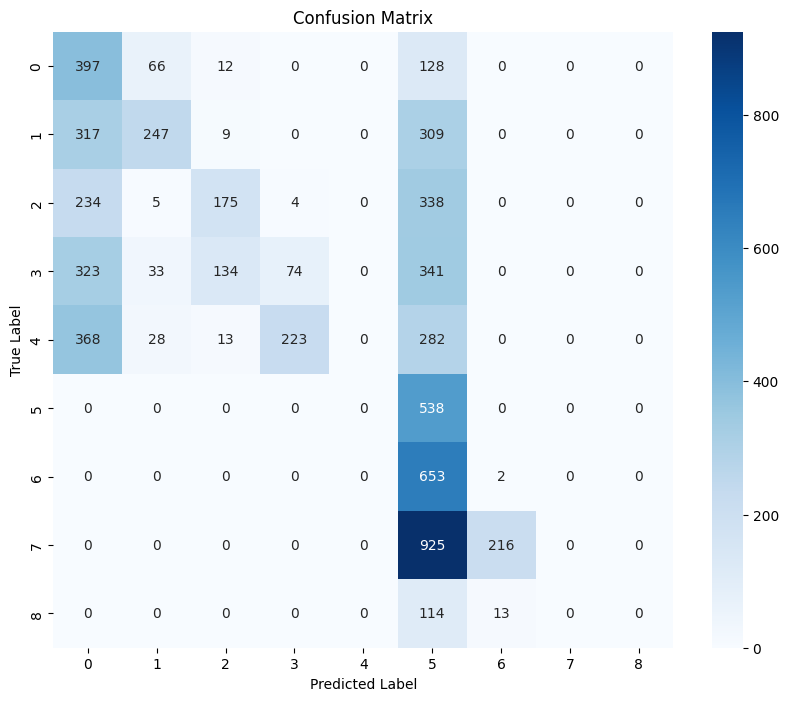

In [19]:
# Example of creating a model and forward passing an input
num_classes = 9

model = EEGNetInspired(num_classes=num_classes)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(model)}")

# Assuming train_loader and test_loader are already defined
print("Training EEGNet:")
train_model(model, train_loader, test_loader)


Total trainable parameters: 115289
Training EEGNet:
Model's output layer: Linear(in_features=128, out_features=9, bias=True)
Unique labels in the dataset: [0 1 2 3 4 5 6 7 8]
Number of classes: 9


Epoch 1/100:  85%|████████▍ | 693/816 [00:04<00:00, 153.44it/s]

Epoch 1/100: 100%|██████████| 816/816 [00:05<00:00, 141.71it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100, Loss: 1.7773, Accuracy: 34.37%, Precision: 0.30, Recall: 0.28, F1 Score: 0.21


Epoch 2/100: 100%|██████████| 816/816 [00:05<00:00, 138.06it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/100, Loss: 1.6372, Accuracy: 35.99%, Precision: 0.24, Recall: 0.28, F1 Score: 0.21


Epoch 3/100: 100%|██████████| 816/816 [00:06<00:00, 135.40it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/100, Loss: 1.6041, Accuracy: 35.73%, Precision: 0.30, Recall: 0.29, F1 Score: 0.26


Epoch 4/100: 100%|██████████| 816/816 [00:05<00:00, 150.95it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/100, Loss: 1.5834, Accuracy: 39.14%, Precision: 0.38, Recall: 0.31, F1 Score: 0.28


Epoch 5/100: 100%|██████████| 816/816 [00:05<00:00, 143.05it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/100, Loss: 1.5893, Accuracy: 24.66%, Precision: 0.32, Recall: 0.22, F1 Score: 0.15


Epoch 6/100: 100%|██████████| 816/816 [00:05<00:00, 143.97it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/100, Loss: 1.5235, Accuracy: 24.06%, Precision: 0.28, Recall: 0.22, F1 Score: 0.19


Epoch 7/100: 100%|██████████| 816/816 [00:06<00:00, 132.79it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/100, Loss: 1.4657, Accuracy: 23.22%, Precision: 0.21, Recall: 0.22, F1 Score: 0.15


Epoch 8/100: 100%|██████████| 816/816 [00:05<00:00, 141.25it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/100, Loss: 1.4532, Accuracy: 23.31%, Precision: 0.25, Recall: 0.22, F1 Score: 0.15


Epoch 9/100: 100%|██████████| 816/816 [00:05<00:00, 141.47it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/100, Loss: 1.4405, Accuracy: 28.29%, Precision: 0.33, Recall: 0.26, F1 Score: 0.23


Epoch 10/100: 100%|██████████| 816/816 [00:05<00:00, 143.30it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/100, Loss: 1.4267, Accuracy: 28.52%, Precision: 0.33, Recall: 0.26, F1 Score: 0.23


Epoch 11/100: 100%|██████████| 816/816 [00:05<00:00, 143.05it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/100, Loss: 1.4271, Accuracy: 25.53%, Precision: 0.32, Recall: 0.25, F1 Score: 0.20


Epoch 12/100: 100%|██████████| 816/816 [00:05<00:00, 137.28it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/100, Loss: 1.4130, Accuracy: 26.90%, Precision: 0.27, Recall: 0.25, F1 Score: 0.19


Epoch 13/100: 100%|██████████| 816/816 [00:05<00:00, 136.29it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/100, Loss: 1.3995, Accuracy: 25.99%, Precision: 0.34, Recall: 0.25, F1 Score: 0.20


Epoch 14/100: 100%|██████████| 816/816 [00:05<00:00, 142.58it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/100, Loss: 1.3960, Accuracy: 28.45%, Precision: 0.50, Recall: 0.26, F1 Score: 0.25


Epoch 15/100: 100%|██████████| 816/816 [00:05<00:00, 145.33it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/100, Loss: 1.3763, Accuracy: 26.62%, Precision: 0.58, Recall: 0.25, F1 Score: 0.21


Epoch 16/100: 100%|██████████| 816/816 [00:05<00:00, 145.04it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/100, Loss: 1.3821, Accuracy: 29.21%, Precision: 0.52, Recall: 0.28, F1 Score: 0.25


Epoch 17/100: 100%|██████████| 816/816 [00:05<00:00, 139.79it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/100, Loss: 1.3603, Accuracy: 23.43%, Precision: 0.32, Recall: 0.22, F1 Score: 0.15


Epoch 18/100: 100%|██████████| 816/816 [00:05<00:00, 140.70it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/100, Loss: 1.3474, Accuracy: 24.32%, Precision: 0.44, Recall: 0.23, F1 Score: 0.17


Epoch 19/100: 100%|██████████| 816/816 [00:05<00:00, 142.52it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/100, Loss: 1.3422, Accuracy: 21.04%, Precision: 0.27, Recall: 0.20, F1 Score: 0.14


Epoch 20/100: 100%|██████████| 816/816 [00:05<00:00, 148.59it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/100, Loss: 1.3396, Accuracy: 29.90%, Precision: 0.58, Recall: 0.29, F1 Score: 0.28


Epoch 21/100: 100%|██████████| 816/816 [00:05<00:00, 143.53it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/100, Loss: 1.3270, Accuracy: 29.98%, Precision: 0.55, Recall: 0.29, F1 Score: 0.28


Epoch 22/100: 100%|██████████| 816/816 [00:05<00:00, 141.48it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/100, Loss: 1.3366, Accuracy: 25.64%, Precision: 0.44, Recall: 0.25, F1 Score: 0.20


Epoch 23/100: 100%|██████████| 816/816 [00:05<00:00, 143.52it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/100, Loss: 1.3244, Accuracy: 31.01%, Precision: 0.53, Recall: 0.30, F1 Score: 0.29


Epoch 24/100: 100%|██████████| 816/816 [00:05<00:00, 138.51it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/100, Loss: 1.3241, Accuracy: 28.81%, Precision: 0.54, Recall: 0.28, F1 Score: 0.26


Epoch 25/100: 100%|██████████| 816/816 [00:05<00:00, 137.84it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/100, Loss: 1.3553, Accuracy: 22.90%, Precision: 0.23, Recall: 0.23, F1 Score: 0.17


Epoch 26/100: 100%|██████████| 816/816 [00:05<00:00, 140.75it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26/100, Loss: 1.3172, Accuracy: 23.14%, Precision: 0.23, Recall: 0.22, F1 Score: 0.15


Epoch 27/100: 100%|██████████| 816/816 [00:06<00:00, 135.61it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27/100, Loss: 1.3022, Accuracy: 29.70%, Precision: 0.51, Recall: 0.29, F1 Score: 0.27


Epoch 28/100: 100%|██████████| 816/816 [00:05<00:00, 145.35it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28/100, Loss: 1.3005, Accuracy: 28.52%, Precision: 0.50, Recall: 0.28, F1 Score: 0.24


Epoch 29/100: 100%|██████████| 816/816 [00:05<00:00, 141.73it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29/100, Loss: 1.2849, Accuracy: 29.34%, Precision: 0.53, Recall: 0.29, F1 Score: 0.26


Epoch 30/100: 100%|██████████| 816/816 [00:05<00:00, 145.16it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/100, Loss: 1.2931, Accuracy: 26.87%, Precision: 0.65, Recall: 0.26, F1 Score: 0.23


Epoch 31/100: 100%|██████████| 816/816 [00:05<00:00, 142.40it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31/100, Loss: 1.3092, Accuracy: 27.05%, Precision: 0.47, Recall: 0.27, F1 Score: 0.23


Epoch 32/100: 100%|██████████| 816/816 [00:05<00:00, 145.30it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32/100, Loss: 1.2859, Accuracy: 24.78%, Precision: 0.41, Recall: 0.24, F1 Score: 0.19


Epoch 33/100: 100%|██████████| 816/816 [00:05<00:00, 142.46it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33/100, Loss: 1.2680, Accuracy: 26.70%, Precision: 0.56, Recall: 0.26, F1 Score: 0.22


Epoch 34/100: 100%|██████████| 816/816 [00:05<00:00, 145.09it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34/100, Loss: 1.2823, Accuracy: 26.28%, Precision: 0.55, Recall: 0.25, F1 Score: 0.21


Epoch 35/100: 100%|██████████| 816/816 [00:05<00:00, 144.54it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35/100, Loss: 1.2709, Accuracy: 26.01%, Precision: 0.54, Recall: 0.25, F1 Score: 0.20


Epoch 36/100: 100%|██████████| 816/816 [00:05<00:00, 139.84it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36/100, Loss: 1.2694, Accuracy: 18.92%, Precision: 0.31, Recall: 0.20, F1 Score: 0.11


Epoch 37/100: 100%|██████████| 816/816 [00:05<00:00, 141.25it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 37/100, Loss: 1.2634, Accuracy: 25.52%, Precision: 0.44, Recall: 0.24, F1 Score: 0.19


Epoch 38/100: 100%|██████████| 816/816 [00:05<00:00, 138.04it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38/100, Loss: 1.2703, Accuracy: 29.31%, Precision: 0.36, Recall: 0.30, F1 Score: 0.24


Epoch 39/100: 100%|██████████| 816/816 [00:05<00:00, 147.03it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39/100, Loss: 1.2511, Accuracy: 25.87%, Precision: 0.44, Recall: 0.25, F1 Score: 0.20


Epoch 40/100: 100%|██████████| 816/816 [00:05<00:00, 149.35it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40/100, Loss: 1.2564, Accuracy: 25.59%, Precision: 0.32, Recall: 0.24, F1 Score: 0.19


Epoch 41/100: 100%|██████████| 816/816 [00:05<00:00, 146.31it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41/100, Loss: 1.2452, Accuracy: 25.87%, Precision: 0.44, Recall: 0.25, F1 Score: 0.20


Epoch 42/100: 100%|██████████| 816/816 [00:06<00:00, 128.82it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 42/100, Loss: 1.2504, Accuracy: 20.78%, Precision: 0.41, Recall: 0.21, F1 Score: 0.14


Epoch 43/100: 100%|██████████| 816/816 [00:05<00:00, 147.11it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 43/100, Loss: 1.2523, Accuracy: 18.52%, Precision: 0.20, Recall: 0.19, F1 Score: 0.10


Epoch 44/100: 100%|██████████| 816/816 [00:05<00:00, 146.42it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 44/100, Loss: 1.2353, Accuracy: 22.39%, Precision: 0.24, Recall: 0.21, F1 Score: 0.14


Epoch 45/100: 100%|██████████| 816/816 [00:05<00:00, 143.44it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 45/100, Loss: 1.2415, Accuracy: 20.13%, Precision: 0.24, Recall: 0.19, F1 Score: 0.11


Epoch 46/100: 100%|██████████| 816/816 [00:05<00:00, 142.58it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 46/100, Loss: 1.2511, Accuracy: 25.64%, Precision: 0.56, Recall: 0.24, F1 Score: 0.19


Epoch 47/100: 100%|██████████| 816/816 [00:05<00:00, 145.33it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 47/100, Loss: 1.2325, Accuracy: 25.59%, Precision: 0.33, Recall: 0.24, F1 Score: 0.19


Epoch 48/100: 100%|██████████| 816/816 [00:05<00:00, 144.84it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 48/100, Loss: 1.2496, Accuracy: 22.54%, Precision: 0.33, Recall: 0.22, F1 Score: 0.15


Epoch 49/100: 100%|██████████| 816/816 [00:05<00:00, 147.41it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 49/100, Loss: 1.2354, Accuracy: 23.46%, Precision: 0.34, Recall: 0.22, F1 Score: 0.16


Epoch 50/100: 100%|██████████| 816/816 [00:05<00:00, 142.21it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 50/100, Loss: 1.2537, Accuracy: 25.20%, Precision: 0.52, Recall: 0.24, F1 Score: 0.19


Epoch 51/100: 100%|██████████| 816/816 [00:05<00:00, 136.16it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 51/100, Loss: 1.2331, Accuracy: 25.95%, Precision: 0.44, Recall: 0.25, F1 Score: 0.20


Epoch 52/100: 100%|██████████| 816/816 [00:05<00:00, 143.13it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 52/100, Loss: 1.2165, Accuracy: 26.27%, Precision: 0.45, Recall: 0.25, F1 Score: 0.21


Epoch 53/100: 100%|██████████| 816/816 [00:05<00:00, 144.67it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 53/100, Loss: 1.2380, Accuracy: 26.33%, Precision: 0.41, Recall: 0.25, F1 Score: 0.20


Epoch 54/100: 100%|██████████| 816/816 [00:05<00:00, 140.84it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 54/100, Loss: 1.2265, Accuracy: 25.06%, Precision: 0.32, Recall: 0.24, F1 Score: 0.19


Epoch 55/100: 100%|██████████| 816/816 [00:05<00:00, 136.25it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 55/100, Loss: 1.2201, Accuracy: 23.02%, Precision: 0.41, Recall: 0.22, F1 Score: 0.16


Epoch 56/100: 100%|██████████| 816/816 [00:05<00:00, 139.50it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 56/100, Loss: 1.2550, Accuracy: 24.18%, Precision: 0.38, Recall: 0.23, F1 Score: 0.18


Epoch 57/100: 100%|██████████| 816/816 [00:05<00:00, 137.07it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 57/100, Loss: 1.2343, Accuracy: 20.15%, Precision: 0.25, Recall: 0.19, F1 Score: 0.12


Epoch 58/100: 100%|██████████| 816/816 [00:05<00:00, 136.53it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 58/100, Loss: 1.2238, Accuracy: 23.14%, Precision: 0.24, Recall: 0.22, F1 Score: 0.15


Epoch 59/100: 100%|██████████| 816/816 [00:05<00:00, 140.53it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 59/100, Loss: 1.2443, Accuracy: 19.80%, Precision: 0.36, Recall: 0.20, F1 Score: 0.12


Epoch 60/100: 100%|██████████| 816/816 [00:05<00:00, 142.42it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 60/100, Loss: 1.2202, Accuracy: 25.90%, Precision: 0.44, Recall: 0.25, F1 Score: 0.20


Epoch 61/100: 100%|██████████| 816/816 [00:05<00:00, 139.90it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 61/100, Loss: 1.2245, Accuracy: 21.88%, Precision: 0.31, Recall: 0.21, F1 Score: 0.14


Epoch 62/100: 100%|██████████| 816/816 [00:05<00:00, 145.94it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 62/100, Loss: 1.2232, Accuracy: 22.74%, Precision: 0.42, Recall: 0.22, F1 Score: 0.15


Epoch 63/100: 100%|██████████| 816/816 [00:05<00:00, 137.38it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 63/100, Loss: 1.2146, Accuracy: 25.89%, Precision: 0.33, Recall: 0.25, F1 Score: 0.20


Epoch 64/100: 100%|██████████| 816/816 [00:05<00:00, 150.38it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 64/100, Loss: 1.2170, Accuracy: 26.01%, Precision: 0.44, Recall: 0.25, F1 Score: 0.20


Epoch 65/100: 100%|██████████| 816/816 [00:05<00:00, 144.19it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 65/100, Loss: 1.2307, Accuracy: 18.48%, Precision: 0.09, Recall: 0.19, F1 Score: 0.10


Epoch 66/100: 100%|██████████| 816/816 [00:06<00:00, 135.83it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 66/100, Loss: 1.2230, Accuracy: 25.81%, Precision: 0.43, Recall: 0.25, F1 Score: 0.20


Epoch 67/100: 100%|██████████| 816/816 [00:05<00:00, 140.19it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 67/100, Loss: 1.2195, Accuracy: 25.58%, Precision: 0.44, Recall: 0.24, F1 Score: 0.19


Epoch 68/100: 100%|██████████| 816/816 [00:05<00:00, 142.48it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 68/100, Loss: 1.2379, Accuracy: 25.75%, Precision: 0.44, Recall: 0.25, F1 Score: 0.20


Epoch 69/100: 100%|██████████| 816/816 [00:05<00:00, 150.25it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 69/100, Loss: 1.2252, Accuracy: 25.95%, Precision: 0.44, Recall: 0.25, F1 Score: 0.20


Epoch 70/100: 100%|██████████| 816/816 [00:05<00:00, 147.36it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 70/100, Loss: 1.2173, Accuracy: 25.43%, Precision: 0.44, Recall: 0.24, F1 Score: 0.19


Epoch 71/100: 100%|██████████| 816/816 [00:05<00:00, 147.34it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 71/100, Loss: 1.2156, Accuracy: 25.58%, Precision: 0.44, Recall: 0.25, F1 Score: 0.20


Epoch 72/100: 100%|██████████| 816/816 [00:05<00:00, 140.78it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 72/100, Loss: 1.2405, Accuracy: 25.58%, Precision: 0.66, Recall: 0.24, F1 Score: 0.19


Epoch 73/100: 100%|██████████| 816/816 [00:05<00:00, 138.15it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 73/100, Loss: 1.2163, Accuracy: 26.50%, Precision: 0.44, Recall: 0.25, F1 Score: 0.21


Epoch 74/100: 100%|██████████| 816/816 [00:05<00:00, 144.01it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 74/100, Loss: 1.2167, Accuracy: 25.55%, Precision: 0.53, Recall: 0.24, F1 Score: 0.19


Epoch 75/100: 100%|██████████| 816/816 [00:05<00:00, 138.58it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 75/100, Loss: 1.2226, Accuracy: 30.26%, Precision: 0.65, Recall: 0.30, F1 Score: 0.28


Epoch 76/100: 100%|██████████| 816/816 [00:05<00:00, 138.26it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 76/100, Loss: 1.2142, Accuracy: 24.44%, Precision: 0.45, Recall: 0.23, F1 Score: 0.17


Epoch 77/100: 100%|██████████| 816/816 [00:05<00:00, 143.11it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 77/100, Loss: 1.2110, Accuracy: 27.80%, Precision: 0.52, Recall: 0.27, F1 Score: 0.25


Epoch 78/100: 100%|██████████| 816/816 [00:05<00:00, 144.17it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 78/100, Loss: 1.2154, Accuracy: 28.92%, Precision: 0.48, Recall: 0.29, F1 Score: 0.26


Epoch 79/100: 100%|██████████| 816/816 [00:05<00:00, 142.72it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 79/100, Loss: 1.2166, Accuracy: 29.55%, Precision: 0.31, Recall: 0.30, F1 Score: 0.24


Epoch 80/100: 100%|██████████| 816/816 [00:05<00:00, 140.30it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 80/100, Loss: 1.1986, Accuracy: 25.93%, Precision: 0.44, Recall: 0.25, F1 Score: 0.20


Epoch 81/100: 100%|██████████| 816/816 [00:05<00:00, 152.13it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 81/100, Loss: 1.1910, Accuracy: 27.07%, Precision: 0.46, Recall: 0.26, F1 Score: 0.23


Epoch 82/100: 100%|██████████| 816/816 [00:05<00:00, 146.63it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 82/100, Loss: 1.1880, Accuracy: 23.20%, Precision: 0.23, Recall: 0.22, F1 Score: 0.15


Epoch 83/100: 100%|██████████| 816/816 [00:05<00:00, 151.80it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 83/100, Loss: 1.1906, Accuracy: 27.37%, Precision: 0.47, Recall: 0.27, F1 Score: 0.24


Epoch 84/100: 100%|██████████| 816/816 [00:05<00:00, 151.34it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 84/100, Loss: 1.1943, Accuracy: 28.20%, Precision: 0.57, Recall: 0.27, F1 Score: 0.24


Epoch 85/100: 100%|██████████| 816/816 [00:05<00:00, 150.13it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 85/100, Loss: 1.1997, Accuracy: 26.12%, Precision: 0.54, Recall: 0.25, F1 Score: 0.21


Epoch 86/100: 100%|██████████| 816/816 [00:05<00:00, 147.90it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 86/100, Loss: 1.1932, Accuracy: 26.65%, Precision: 0.55, Recall: 0.25, F1 Score: 0.21


Epoch 87/100: 100%|██████████| 816/816 [00:05<00:00, 151.41it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 87/100, Loss: 1.1806, Accuracy: 26.22%, Precision: 0.44, Recall: 0.25, F1 Score: 0.20


Epoch 88/100: 100%|██████████| 816/816 [00:05<00:00, 144.51it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 88/100, Loss: 1.1952, Accuracy: 27.85%, Precision: 0.46, Recall: 0.27, F1 Score: 0.23


Epoch 89/100: 100%|██████████| 816/816 [00:05<00:00, 140.55it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 89/100, Loss: 1.2088, Accuracy: 29.75%, Precision: 0.46, Recall: 0.30, F1 Score: 0.25


Epoch 90/100: 100%|██████████| 816/816 [00:05<00:00, 142.59it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 90/100, Loss: 1.1989, Accuracy: 28.28%, Precision: 0.56, Recall: 0.28, F1 Score: 0.24


Epoch 91/100: 100%|██████████| 816/816 [00:05<00:00, 143.73it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 91/100, Loss: 1.1986, Accuracy: 26.47%, Precision: 0.35, Recall: 0.25, F1 Score: 0.23


Epoch 92/100: 100%|██████████| 816/816 [00:05<00:00, 142.86it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 92/100, Loss: 1.1962, Accuracy: 25.67%, Precision: 0.48, Recall: 0.24, F1 Score: 0.20


Epoch 93/100: 100%|██████████| 816/816 [00:05<00:00, 138.94it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 93/100, Loss: 1.1813, Accuracy: 26.79%, Precision: 0.56, Recall: 0.26, F1 Score: 0.22


Epoch 94/100: 100%|██████████| 816/816 [00:05<00:00, 147.47it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 94/100, Loss: 1.1782, Accuracy: 26.42%, Precision: 0.55, Recall: 0.25, F1 Score: 0.22


Epoch 95/100: 100%|██████████| 816/816 [00:05<00:00, 145.67it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 95/100, Loss: 1.1904, Accuracy: 25.35%, Precision: 0.32, Recall: 0.25, F1 Score: 0.20


Epoch 96/100: 100%|██████████| 816/816 [00:05<00:00, 145.75it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 96/100, Loss: 1.2127, Accuracy: 23.55%, Precision: 0.53, Recall: 0.24, F1 Score: 0.19


Epoch 97/100: 100%|██████████| 816/816 [00:05<00:00, 146.87it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 97/100, Loss: 1.2627, Accuracy: 23.19%, Precision: 0.21, Recall: 0.22, F1 Score: 0.15


Epoch 98/100: 100%|██████████| 816/816 [00:05<00:00, 148.05it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 98/100, Loss: 1.2430, Accuracy: 23.37%, Precision: 0.21, Recall: 0.22, F1 Score: 0.15


Epoch 99/100: 100%|██████████| 816/816 [00:05<00:00, 148.79it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 99/100, Loss: 1.2014, Accuracy: 26.76%, Precision: 0.43, Recall: 0.26, F1 Score: 0.22


Epoch 100/100: 100%|██████████| 816/816 [00:05<00:00, 142.80it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 100/100, Loss: 1.1985, Accuracy: 25.49%, Precision: 0.40, Recall: 0.24, F1 Score: 0.19


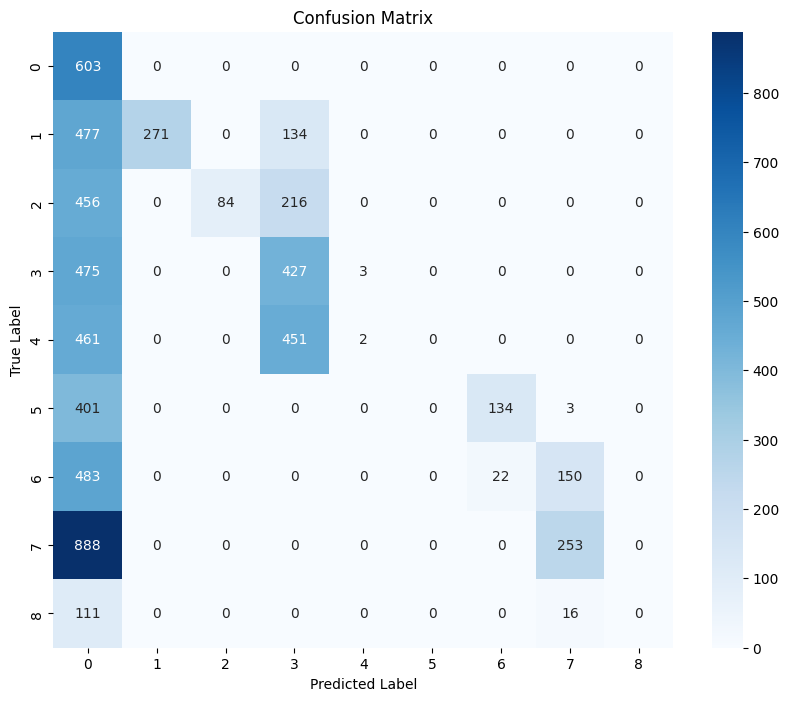

In [30]:
model = EEGNetInspiredBetter(num_classes=num_classes)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(model)}")

# Assuming train_loader and test_loader are already defined
print("Training EEGNet:")
train_model(model, train_loader, test_loader)

In [37]:
import torch
import torch.nn as nn

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channel // reduction, channel, bias=False),  # fixed the number of output neurons here
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()  # (batch_size, channels, time)
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class EEGNetWithAttention(nn.Module):
    def __init__(self, num_classes=8):
        super(EEGNetWithAttention, self).__init__()
        
        # Temporal Convolution
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=32, padding=16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.AvgPool1d(2),
            nn.Dropout(0.3)
        )
        
        # Depthwise Convolution
        self.conv2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=16, groups=16, padding=8),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.AvgPool1d(4),
            nn.Dropout(0.3)
        )
        
        # Separable Convolution
        self.conv3 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.AvgPool1d(2),
            nn.Dropout(0.3)
        )
        
        # Channel Attention Block
        self.se_block = SEBlock(channel=64)
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Classifier
        self.fc1 = nn.Linear(64 * 13, 128)  # make sure the size matches what comes out of flatten
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, 1, 210)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # Apply the channel attention mechanism
        x = self.se_block(x)
        
        x = self.flatten(x)  # flatten after attention block
        x = self.fc1(x)
        x = self.fc2(x)
        return x


Total trainable parameters: 115801
Training EEGNet:
Model's output layer: Linear(in_features=128, out_features=9, bias=True)
Unique labels in the dataset: [0 1 2 3 4 5 6 7 8]
Number of classes: 9


Epoch 1/100:   7%|▋         | 58/816 [00:00<00:07, 97.24it/s]

Epoch 1/100: 100%|██████████| 816/816 [00:06<00:00, 121.74it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100, Loss: 1.7577, Accuracy: 32.48%, Precision: 0.26, Recall: 0.25, F1 Score: 0.21


Epoch 2/100: 100%|██████████| 816/816 [00:06<00:00, 134.06it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/100, Loss: 1.6216, Accuracy: 37.36%, Precision: 0.27, Recall: 0.29, F1 Score: 0.24


Epoch 3/100: 100%|██████████| 816/816 [00:06<00:00, 130.06it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/100, Loss: 1.5764, Accuracy: 39.58%, Precision: 0.28, Recall: 0.31, F1 Score: 0.27


Epoch 4/100: 100%|██████████| 816/816 [00:06<00:00, 129.55it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/100, Loss: 1.5484, Accuracy: 27.07%, Precision: 0.29, Recall: 0.23, F1 Score: 0.23


Epoch 5/100: 100%|██████████| 816/816 [00:06<00:00, 129.34it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/100, Loss: 1.5266, Accuracy: 41.94%, Precision: 0.40, Recall: 0.33, F1 Score: 0.31


Epoch 6/100: 100%|██████████| 816/816 [00:06<00:00, 131.83it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/100, Loss: 1.5064, Accuracy: 29.87%, Precision: 0.49, Recall: 0.27, F1 Score: 0.26


Epoch 7/100: 100%|██████████| 816/816 [00:06<00:00, 129.18it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/100, Loss: 1.4826, Accuracy: 28.08%, Precision: 0.27, Recall: 0.25, F1 Score: 0.22


Epoch 8/100: 100%|██████████| 816/816 [00:06<00:00, 127.08it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/100, Loss: 1.4551, Accuracy: 28.40%, Precision: 0.27, Recall: 0.27, F1 Score: 0.21


Epoch 9/100: 100%|██████████| 816/816 [00:06<00:00, 128.54it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/100, Loss: 1.4253, Accuracy: 17.90%, Precision: 0.07, Recall: 0.14, F1 Score: 0.06


Epoch 10/100: 100%|██████████| 816/816 [00:06<00:00, 123.86it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/100, Loss: 1.3943, Accuracy: 32.30%, Precision: 0.43, Recall: 0.29, F1 Score: 0.28


Epoch 11/100: 100%|██████████| 816/816 [00:06<00:00, 128.09it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/100, Loss: 1.3796, Accuracy: 19.00%, Precision: 0.35, Recall: 0.20, F1 Score: 0.12


Epoch 12/100: 100%|██████████| 816/816 [00:06<00:00, 120.35it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/100, Loss: 1.3584, Accuracy: 33.83%, Precision: 0.47, Recall: 0.33, F1 Score: 0.33


Epoch 13/100: 100%|██████████| 816/816 [00:06<00:00, 124.13it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/100, Loss: 1.3351, Accuracy: 27.14%, Precision: 0.42, Recall: 0.26, F1 Score: 0.23


Epoch 14/100: 100%|██████████| 816/816 [00:06<00:00, 124.98it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/100, Loss: 1.3162, Accuracy: 31.71%, Precision: 0.49, Recall: 0.32, F1 Score: 0.26


Epoch 15/100: 100%|██████████| 816/816 [00:06<00:00, 130.16it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/100, Loss: 1.3045, Accuracy: 30.15%, Precision: 0.42, Recall: 0.29, F1 Score: 0.27


Epoch 16/100: 100%|██████████| 816/816 [00:06<00:00, 126.97it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/100, Loss: 1.3067, Accuracy: 27.37%, Precision: 0.54, Recall: 0.26, F1 Score: 0.26


Epoch 17/100: 100%|██████████| 816/816 [00:06<00:00, 127.20it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/100, Loss: 1.2895, Accuracy: 26.04%, Precision: 0.49, Recall: 0.25, F1 Score: 0.21


Epoch 18/100: 100%|██████████| 816/816 [00:06<00:00, 132.54it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/100, Loss: 1.2975, Accuracy: 23.83%, Precision: 0.49, Recall: 0.22, F1 Score: 0.16


Epoch 19/100: 100%|██████████| 816/816 [00:06<00:00, 130.06it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/100, Loss: 1.2901, Accuracy: 34.87%, Precision: 0.70, Recall: 0.35, F1 Score: 0.35


Epoch 20/100: 100%|██████████| 816/816 [00:06<00:00, 128.31it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/100, Loss: 1.2904, Accuracy: 23.82%, Precision: 0.50, Recall: 0.22, F1 Score: 0.18


Epoch 21/100: 100%|██████████| 816/816 [00:06<00:00, 134.70it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/100, Loss: 1.2746, Accuracy: 31.56%, Precision: 0.52, Recall: 0.31, F1 Score: 0.29


Epoch 22/100: 100%|██████████| 816/816 [00:06<00:00, 133.42it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/100, Loss: 1.2802, Accuracy: 26.12%, Precision: 0.43, Recall: 0.25, F1 Score: 0.21


Epoch 23/100: 100%|██████████| 816/816 [00:06<00:00, 128.89it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/100, Loss: 1.2675, Accuracy: 29.03%, Precision: 0.50, Recall: 0.28, F1 Score: 0.25


Epoch 24/100: 100%|██████████| 816/816 [00:06<00:00, 128.97it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/100, Loss: 1.2818, Accuracy: 29.43%, Precision: 0.64, Recall: 0.31, F1 Score: 0.28


Epoch 25/100: 100%|██████████| 816/816 [00:06<00:00, 129.34it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/100, Loss: 1.2719, Accuracy: 29.41%, Precision: 0.37, Recall: 0.28, F1 Score: 0.25


Epoch 26/100: 100%|██████████| 816/816 [00:06<00:00, 123.58it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26/100, Loss: 1.2775, Accuracy: 21.94%, Precision: 0.15, Recall: 0.20, F1 Score: 0.14


Epoch 27/100: 100%|██████████| 816/816 [00:06<00:00, 127.62it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27/100, Loss: 1.2734, Accuracy: 31.74%, Precision: 0.61, Recall: 0.31, F1 Score: 0.29


Epoch 28/100: 100%|██████████| 816/816 [00:06<00:00, 127.49it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28/100, Loss: 1.2857, Accuracy: 29.14%, Precision: 0.44, Recall: 0.28, F1 Score: 0.24


Epoch 29/100: 100%|██████████| 816/816 [00:06<00:00, 121.29it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29/100, Loss: 1.2755, Accuracy: 27.59%, Precision: 0.38, Recall: 0.27, F1 Score: 0.22


Epoch 30/100: 100%|██████████| 816/816 [00:06<00:00, 129.42it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/100, Loss: 1.2627, Accuracy: 26.15%, Precision: 0.26, Recall: 0.25, F1 Score: 0.21


Epoch 31/100: 100%|██████████| 816/816 [00:06<00:00, 128.39it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31/100, Loss: 1.2702, Accuracy: 31.07%, Precision: 0.45, Recall: 0.29, F1 Score: 0.27


Epoch 32/100: 100%|██████████| 816/816 [00:06<00:00, 125.17it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32/100, Loss: 1.2346, Accuracy: 30.88%, Precision: 0.47, Recall: 0.30, F1 Score: 0.28


Epoch 33/100: 100%|██████████| 816/816 [00:06<00:00, 120.29it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33/100, Loss: 1.2364, Accuracy: 28.98%, Precision: 0.37, Recall: 0.28, F1 Score: 0.25


Epoch 34/100: 100%|██████████| 816/816 [00:06<00:00, 120.26it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34/100, Loss: 1.2421, Accuracy: 30.04%, Precision: 0.52, Recall: 0.29, F1 Score: 0.27


Epoch 35/100: 100%|██████████| 816/816 [00:06<00:00, 123.58it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35/100, Loss: 1.2379, Accuracy: 32.74%, Precision: 0.50, Recall: 0.32, F1 Score: 0.31


Epoch 36/100: 100%|██████████| 816/816 [00:06<00:00, 117.17it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36/100, Loss: 1.2285, Accuracy: 30.96%, Precision: 0.51, Recall: 0.31, F1 Score: 0.29


Epoch 37/100: 100%|██████████| 816/816 [00:06<00:00, 129.70it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 37/100, Loss: 1.2372, Accuracy: 26.05%, Precision: 0.33, Recall: 0.23, F1 Score: 0.19


Epoch 38/100: 100%|██████████| 816/816 [00:06<00:00, 128.10it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38/100, Loss: 1.2323, Accuracy: 28.81%, Precision: 0.44, Recall: 0.27, F1 Score: 0.24


Epoch 39/100: 100%|██████████| 816/816 [00:07<00:00, 116.20it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39/100, Loss: 1.2420, Accuracy: 28.65%, Precision: 0.37, Recall: 0.28, F1 Score: 0.25


Epoch 40/100: 100%|██████████| 816/816 [00:06<00:00, 124.80it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40/100, Loss: 1.2364, Accuracy: 29.32%, Precision: 0.50, Recall: 0.29, F1 Score: 0.26


Epoch 41/100: 100%|██████████| 816/816 [00:06<00:00, 123.84it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41/100, Loss: 1.2318, Accuracy: 28.60%, Precision: 0.37, Recall: 0.28, F1 Score: 0.23


Epoch 42/100: 100%|██████████| 816/816 [00:06<00:00, 120.46it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 42/100, Loss: 1.2412, Accuracy: 29.60%, Precision: 0.46, Recall: 0.29, F1 Score: 0.26


Epoch 43/100: 100%|██████████| 816/816 [00:07<00:00, 102.60it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 43/100, Loss: 1.2241, Accuracy: 29.17%, Precision: 0.49, Recall: 0.28, F1 Score: 0.25


Epoch 44/100: 100%|██████████| 816/816 [00:07<00:00, 114.42it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 44/100, Loss: 1.2102, Accuracy: 29.55%, Precision: 0.39, Recall: 0.29, F1 Score: 0.26


Epoch 45/100: 100%|██████████| 816/816 [00:06<00:00, 120.75it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 45/100, Loss: 1.2167, Accuracy: 27.62%, Precision: 0.50, Recall: 0.27, F1 Score: 0.24


Epoch 46/100: 100%|██████████| 816/816 [00:06<00:00, 120.47it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 46/100, Loss: 1.2209, Accuracy: 34.15%, Precision: 0.56, Recall: 0.34, F1 Score: 0.34


Epoch 47/100: 100%|██████████| 816/816 [00:06<00:00, 125.00it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 47/100, Loss: 1.2258, Accuracy: 31.47%, Precision: 0.45, Recall: 0.31, F1 Score: 0.27


Epoch 48/100: 100%|██████████| 816/816 [00:06<00:00, 118.97it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 48/100, Loss: 1.2083, Accuracy: 32.00%, Precision: 0.43, Recall: 0.31, F1 Score: 0.27


Epoch 49/100: 100%|██████████| 816/816 [00:06<00:00, 118.57it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 49/100, Loss: 1.2050, Accuracy: 30.96%, Precision: 0.43, Recall: 0.31, F1 Score: 0.29


Epoch 50/100: 100%|██████████| 816/816 [00:06<00:00, 121.54it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 50/100, Loss: 1.2154, Accuracy: 29.92%, Precision: 0.42, Recall: 0.28, F1 Score: 0.26


Epoch 51/100: 100%|██████████| 816/816 [00:06<00:00, 122.51it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 51/100, Loss: 1.2288, Accuracy: 30.62%, Precision: 0.37, Recall: 0.29, F1 Score: 0.26


Epoch 52/100: 100%|██████████| 816/816 [00:06<00:00, 128.67it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 52/100, Loss: 1.2277, Accuracy: 27.80%, Precision: 0.32, Recall: 0.26, F1 Score: 0.22


Epoch 53/100: 100%|██████████| 816/816 [00:06<00:00, 127.36it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 53/100, Loss: 1.2286, Accuracy: 29.23%, Precision: 0.35, Recall: 0.28, F1 Score: 0.24


Epoch 54/100: 100%|██████████| 816/816 [00:06<00:00, 129.95it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 54/100, Loss: 1.2188, Accuracy: 29.58%, Precision: 0.44, Recall: 0.29, F1 Score: 0.27


Epoch 55/100: 100%|██████████| 816/816 [00:06<00:00, 132.13it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 55/100, Loss: 1.2062, Accuracy: 32.39%, Precision: 0.51, Recall: 0.32, F1 Score: 0.29


Epoch 56/100: 100%|██████████| 816/816 [00:06<00:00, 129.37it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 56/100, Loss: 1.2050, Accuracy: 27.40%, Precision: 0.39, Recall: 0.26, F1 Score: 0.23


Epoch 57/100: 100%|██████████| 816/816 [00:06<00:00, 132.51it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 57/100, Loss: 1.2041, Accuracy: 32.08%, Precision: 0.49, Recall: 0.33, F1 Score: 0.27


Epoch 58/100: 100%|██████████| 816/816 [00:06<00:00, 130.68it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 58/100, Loss: 1.2049, Accuracy: 29.75%, Precision: 0.37, Recall: 0.28, F1 Score: 0.26


Epoch 59/100: 100%|██████████| 816/816 [00:06<00:00, 135.69it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 59/100, Loss: 1.1941, Accuracy: 33.25%, Precision: 0.60, Recall: 0.33, F1 Score: 0.31


Epoch 60/100: 100%|██████████| 816/816 [00:05<00:00, 136.43it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 60/100, Loss: 1.2001, Accuracy: 32.79%, Precision: 0.42, Recall: 0.33, F1 Score: 0.28


Epoch 61/100: 100%|██████████| 816/816 [00:05<00:00, 136.78it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 61/100, Loss: 1.1880, Accuracy: 29.60%, Precision: 0.33, Recall: 0.28, F1 Score: 0.25


Epoch 62/100: 100%|██████████| 816/816 [00:05<00:00, 137.56it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 62/100, Loss: 1.1994, Accuracy: 35.04%, Precision: 0.55, Recall: 0.36, F1 Score: 0.30


Epoch 63/100: 100%|██████████| 816/816 [00:06<00:00, 130.45it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 63/100, Loss: 1.2038, Accuracy: 27.73%, Precision: 0.38, Recall: 0.25, F1 Score: 0.21


Epoch 64/100: 100%|██████████| 816/816 [00:05<00:00, 140.36it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 64/100, Loss: 1.1905, Accuracy: 27.30%, Precision: 0.33, Recall: 0.26, F1 Score: 0.23


Epoch 65/100: 100%|██████████| 816/816 [00:05<00:00, 137.33it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 65/100, Loss: 1.1956, Accuracy: 28.78%, Precision: 0.43, Recall: 0.29, F1 Score: 0.26


Epoch 66/100: 100%|██████████| 816/816 [00:06<00:00, 135.52it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 66/100, Loss: 1.2113, Accuracy: 28.06%, Precision: 0.29, Recall: 0.27, F1 Score: 0.23


Epoch 67/100: 100%|██████████| 816/816 [00:05<00:00, 138.67it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 67/100, Loss: 1.1996, Accuracy: 27.47%, Precision: 0.50, Recall: 0.26, F1 Score: 0.21


Epoch 68/100: 100%|██████████| 816/816 [00:05<00:00, 141.62it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 68/100, Loss: 1.2018, Accuracy: 30.64%, Precision: 0.55, Recall: 0.29, F1 Score: 0.28


Epoch 69/100: 100%|██████████| 816/816 [00:05<00:00, 140.32it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 69/100, Loss: 1.1800, Accuracy: 31.50%, Precision: 0.43, Recall: 0.30, F1 Score: 0.29


Epoch 70/100: 100%|██████████| 816/816 [00:06<00:00, 133.66it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 70/100, Loss: 1.2171, Accuracy: 35.87%, Precision: 0.57, Recall: 0.36, F1 Score: 0.32


Epoch 71/100: 100%|██████████| 816/816 [00:05<00:00, 136.12it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 71/100, Loss: 1.2059, Accuracy: 26.08%, Precision: 0.44, Recall: 0.26, F1 Score: 0.23


Epoch 72/100: 100%|██████████| 816/816 [00:06<00:00, 135.43it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 72/100, Loss: 1.2007, Accuracy: 30.52%, Precision: 0.48, Recall: 0.29, F1 Score: 0.28


Epoch 73/100: 100%|██████████| 816/816 [00:06<00:00, 131.01it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 73/100, Loss: 1.2001, Accuracy: 33.02%, Precision: 0.51, Recall: 0.32, F1 Score: 0.30


Epoch 74/100: 100%|██████████| 816/816 [00:06<00:00, 132.12it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 74/100, Loss: 1.1956, Accuracy: 27.02%, Precision: 0.28, Recall: 0.25, F1 Score: 0.20


Epoch 75/100: 100%|██████████| 816/816 [00:06<00:00, 127.68it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 75/100, Loss: 1.1869, Accuracy: 32.46%, Precision: 0.52, Recall: 0.31, F1 Score: 0.30


Epoch 76/100: 100%|██████████| 816/816 [00:06<00:00, 130.03it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 76/100, Loss: 1.1851, Accuracy: 28.68%, Precision: 0.47, Recall: 0.28, F1 Score: 0.25


Epoch 77/100: 100%|██████████| 816/816 [00:06<00:00, 121.51it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 77/100, Loss: 1.1760, Accuracy: 22.47%, Precision: 0.37, Recall: 0.21, F1 Score: 0.17


Epoch 78/100: 100%|██████████| 816/816 [00:07<00:00, 115.99it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 78/100, Loss: 1.1749, Accuracy: 30.59%, Precision: 0.53, Recall: 0.30, F1 Score: 0.27


Epoch 79/100: 100%|██████████| 816/816 [00:08<00:00, 92.44it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 79/100, Loss: 1.1705, Accuracy: 28.69%, Precision: 0.38, Recall: 0.26, F1 Score: 0.22


Epoch 80/100: 100%|██████████| 816/816 [00:06<00:00, 131.11it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 80/100, Loss: 1.1763, Accuracy: 23.78%, Precision: 0.38, Recall: 0.23, F1 Score: 0.18


Epoch 81/100: 100%|██████████| 816/816 [00:05<00:00, 136.20it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 81/100, Loss: 1.1946, Accuracy: 29.06%, Precision: 0.27, Recall: 0.28, F1 Score: 0.23


Epoch 82/100: 100%|██████████| 816/816 [00:06<00:00, 135.22it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 82/100, Loss: 1.1728, Accuracy: 28.65%, Precision: 0.47, Recall: 0.28, F1 Score: 0.25


Epoch 83/100: 100%|██████████| 816/816 [00:06<00:00, 133.61it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 83/100, Loss: 1.1697, Accuracy: 26.48%, Precision: 0.58, Recall: 0.25, F1 Score: 0.22


Epoch 84/100: 100%|██████████| 816/816 [00:06<00:00, 127.54it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 84/100, Loss: 1.1733, Accuracy: 26.73%, Precision: 0.34, Recall: 0.24, F1 Score: 0.21


Epoch 85/100: 100%|██████████| 816/816 [00:06<00:00, 133.96it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 85/100, Loss: 1.1566, Accuracy: 27.88%, Precision: 0.29, Recall: 0.27, F1 Score: 0.23


Epoch 86/100: 100%|██████████| 816/816 [00:06<00:00, 118.16it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 86/100, Loss: 1.1597, Accuracy: 30.39%, Precision: 0.48, Recall: 0.29, F1 Score: 0.27


Epoch 87/100: 100%|██████████| 816/816 [00:06<00:00, 127.71it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 87/100, Loss: 1.1617, Accuracy: 34.29%, Precision: 0.55, Recall: 0.33, F1 Score: 0.32


Epoch 88/100: 100%|██████████| 816/816 [00:06<00:00, 126.06it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 88/100, Loss: 1.1776, Accuracy: 22.67%, Precision: 0.23, Recall: 0.22, F1 Score: 0.16


Epoch 89/100: 100%|██████████| 816/816 [00:06<00:00, 133.04it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 89/100, Loss: 1.1629, Accuracy: 28.55%, Precision: 0.31, Recall: 0.27, F1 Score: 0.24


Epoch 90/100: 100%|██████████| 816/816 [00:06<00:00, 130.05it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 90/100, Loss: 1.1599, Accuracy: 29.06%, Precision: 0.42, Recall: 0.28, F1 Score: 0.24


Epoch 91/100: 100%|██████████| 816/816 [00:06<00:00, 132.92it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 91/100, Loss: 1.1659, Accuracy: 29.90%, Precision: 0.58, Recall: 0.28, F1 Score: 0.25


Epoch 92/100: 100%|██████████| 816/816 [00:06<00:00, 126.82it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 92/100, Loss: 1.1552, Accuracy: 32.57%, Precision: 0.47, Recall: 0.31, F1 Score: 0.30


Epoch 93/100: 100%|██████████| 816/816 [00:06<00:00, 132.87it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 93/100, Loss: 1.1537, Accuracy: 33.60%, Precision: 0.56, Recall: 0.32, F1 Score: 0.31


Epoch 94/100: 100%|██████████| 816/816 [00:06<00:00, 134.85it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 94/100, Loss: 1.1392, Accuracy: 28.78%, Precision: 0.43, Recall: 0.27, F1 Score: 0.24


Epoch 95/100: 100%|██████████| 816/816 [00:06<00:00, 133.50it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 95/100, Loss: 1.1483, Accuracy: 27.28%, Precision: 0.34, Recall: 0.26, F1 Score: 0.23


Epoch 96/100: 100%|██████████| 816/816 [00:06<00:00, 130.23it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 96/100, Loss: 1.1460, Accuracy: 30.06%, Precision: 0.51, Recall: 0.29, F1 Score: 0.26


Epoch 97/100: 100%|██████████| 816/816 [00:06<00:00, 118.23it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 97/100, Loss: 1.1387, Accuracy: 30.09%, Precision: 0.46, Recall: 0.29, F1 Score: 0.26


Epoch 98/100: 100%|██████████| 816/816 [00:06<00:00, 127.75it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 98/100, Loss: 1.1443, Accuracy: 31.18%, Precision: 0.41, Recall: 0.31, F1 Score: 0.28


Epoch 99/100: 100%|██████████| 816/816 [00:06<00:00, 125.72it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 99/100, Loss: 1.1413, Accuracy: 32.80%, Precision: 0.51, Recall: 0.32, F1 Score: 0.30


Epoch 100/100: 100%|██████████| 816/816 [00:06<00:00, 118.15it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 100/100, Loss: 1.1398, Accuracy: 27.56%, Precision: 0.39, Recall: 0.27, F1 Score: 0.23


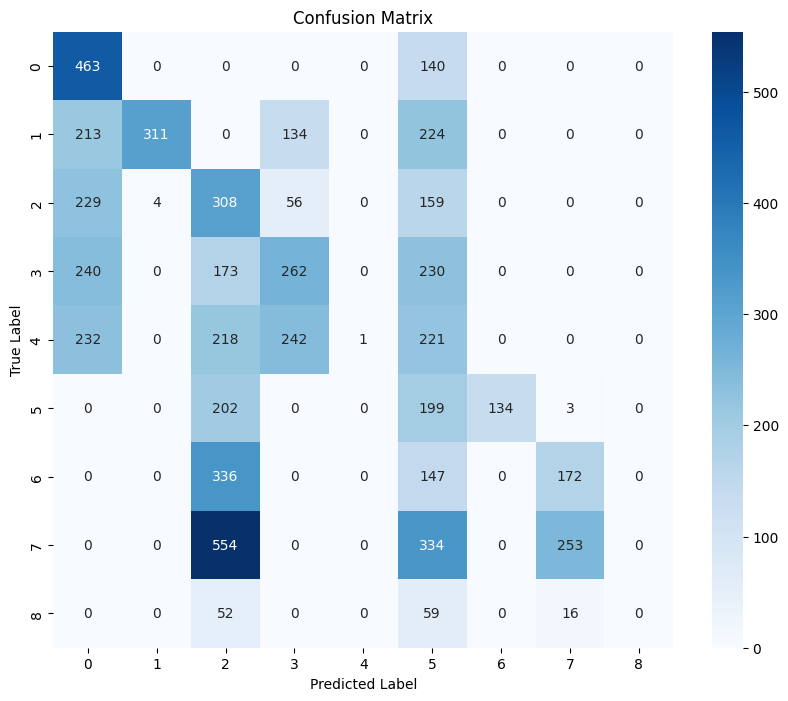

In [38]:
model = EEGNetWithAttention(num_classes=num_classes)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(model)}")

# Assuming train_loader and test_loader are already defined
print("Training EEGNet:")
train_model(model, train_loader, test_loader)

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GroupDepthwiseConv(nn.Module):
    def __init__(self, in_channels, out_channels, groups, kernel_size=3, padding=1):
        super(GroupDepthwiseConv, self).__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1, groups=groups)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class TemporalAttention(nn.Module):
    def __init__(self, input_dim, num_heads):
        super(TemporalAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads, batch_first=True)
        
    def forward(self, x):
        # Assume x shape (batch_size, seq_length, features)
        attn_output, _ = self.attention(x, x, x)
        return attn_output

class EEGNetTESANet(nn.Module):
    def __init__(self, num_classes=9):
        super(EEGNetTESANet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=32, padding=16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.AvgPool1d(2),
            nn.Dropout(0.3)
        )
        
        self.conv2 = nn.Sequential(
            GroupDepthwiseConv(16, 32, groups=4, kernel_size=16, padding=8),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.AvgPool1d(4),
            nn.Dropout(0.3)
        )
        
        self.conv3 = nn.Sequential(
            GroupDepthwiseConv(32, 64, groups=8, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.AvgPool1d(2),
            nn.Dropout(0.3)
        )
        
        # Temporal Attention
        self.temporal_attention = TemporalAttention(input_dim=64, num_heads=4)
        
        # Classifier
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 13, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, 1, 210)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # Reshape for attention mechanism (batch_size, seq_length, features)
        x = x.permute(0, 2, 1)
        x = self.temporal_attention(x)
        
        # Reshape back (batch_size, features, seq_length)
        x = x.permute(0, 2, 1)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


Total trainable parameters: 126057
Training EEGNet:
Model's output layer: Linear(in_features=128, out_features=9, bias=True)
Unique labels in the dataset: [0 1 2 3 4 5 6 7 8]
Number of classes: 9


Epoch 1/100: 100%|██████████| 816/816 [00:09<00:00, 87.18it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100, Loss: 1.8199, Accuracy: 32.36%, Precision: 0.22, Recall: 0.24, F1 Score: 0.17


Epoch 2/100: 100%|██████████| 816/816 [00:09<00:00, 87.82it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/100, Loss: 1.7052, Accuracy: 34.89%, Precision: 0.34, Recall: 0.26, F1 Score: 0.21


Epoch 3/100: 100%|██████████| 816/816 [00:09<00:00, 90.59it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/100, Loss: 1.6382, Accuracy: 33.61%, Precision: 0.34, Recall: 0.26, F1 Score: 0.19


Epoch 4/100: 100%|██████████| 816/816 [00:09<00:00, 86.38it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/100, Loss: 1.6136, Accuracy: 36.45%, Precision: 0.41, Recall: 0.29, F1 Score: 0.26


Epoch 5/100: 100%|██████████| 816/816 [00:09<00:00, 88.47it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/100, Loss: 1.5960, Accuracy: 36.74%, Precision: 0.35, Recall: 0.29, F1 Score: 0.26


Epoch 6/100: 100%|██████████| 816/816 [00:09<00:00, 83.46it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/100, Loss: 1.5853, Accuracy: 20.81%, Precision: 0.20, Recall: 0.22, F1 Score: 0.16


Epoch 7/100: 100%|██████████| 816/816 [00:09<00:00, 90.66it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/100, Loss: 1.5810, Accuracy: 36.70%, Precision: 0.29, Recall: 0.29, F1 Score: 0.25


Epoch 8/100: 100%|██████████| 816/816 [00:08<00:00, 92.76it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/100, Loss: 1.5695, Accuracy: 35.45%, Precision: 0.34, Recall: 0.28, F1 Score: 0.24


Epoch 9/100: 100%|██████████| 816/816 [00:08<00:00, 92.72it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/100, Loss: 1.5598, Accuracy: 26.41%, Precision: 0.29, Recall: 0.23, F1 Score: 0.20


Epoch 10/100: 100%|██████████| 816/816 [00:09<00:00, 87.74it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/100, Loss: 1.5540, Accuracy: 20.32%, Precision: 0.29, Recall: 0.21, F1 Score: 0.13


Epoch 11/100: 100%|██████████| 816/816 [00:09<00:00, 90.29it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/100, Loss: 1.5446, Accuracy: 35.45%, Precision: 0.26, Recall: 0.28, F1 Score: 0.23


Epoch 12/100: 100%|██████████| 816/816 [00:08<00:00, 91.82it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/100, Loss: 1.5299, Accuracy: 39.37%, Precision: 0.40, Recall: 0.31, F1 Score: 0.26


Epoch 13/100: 100%|██████████| 816/816 [00:09<00:00, 87.60it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/100, Loss: 1.5355, Accuracy: 21.71%, Precision: 0.21, Recall: 0.21, F1 Score: 0.15


Epoch 14/100: 100%|██████████| 816/816 [00:09<00:00, 87.24it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/100, Loss: 1.5285, Accuracy: 35.90%, Precision: 0.36, Recall: 0.27, F1 Score: 0.22


Epoch 15/100: 100%|██████████| 816/816 [00:09<00:00, 90.61it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/100, Loss: 1.5215, Accuracy: 19.00%, Precision: 0.23, Recall: 0.19, F1 Score: 0.14


Epoch 16/100: 100%|██████████| 816/816 [00:09<00:00, 88.54it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/100, Loss: 1.5113, Accuracy: 34.18%, Precision: 0.35, Recall: 0.29, F1 Score: 0.23


Epoch 17/100: 100%|██████████| 816/816 [00:09<00:00, 87.71it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/100, Loss: 1.5052, Accuracy: 38.78%, Precision: 0.32, Recall: 0.31, F1 Score: 0.26


Epoch 18/100: 100%|██████████| 816/816 [00:09<00:00, 84.44it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/100, Loss: 1.5142, Accuracy: 28.89%, Precision: 0.38, Recall: 0.25, F1 Score: 0.23


Epoch 19/100: 100%|██████████| 816/816 [00:09<00:00, 87.46it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/100, Loss: 1.5078, Accuracy: 18.86%, Precision: 0.15, Recall: 0.19, F1 Score: 0.11


Epoch 20/100: 100%|██████████| 816/816 [00:09<00:00, 86.61it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/100, Loss: 1.5037, Accuracy: 22.77%, Precision: 0.18, Recall: 0.21, F1 Score: 0.14


Epoch 21/100: 100%|██████████| 816/816 [00:09<00:00, 85.84it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/100, Loss: 1.4989, Accuracy: 41.88%, Precision: 0.49, Recall: 0.33, F1 Score: 0.32


Epoch 22/100: 100%|██████████| 816/816 [00:09<00:00, 88.42it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/100, Loss: 1.4912, Accuracy: 40.41%, Precision: 0.46, Recall: 0.33, F1 Score: 0.30


Epoch 23/100: 100%|██████████| 816/816 [00:09<00:00, 88.60it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/100, Loss: 1.4872, Accuracy: 41.82%, Precision: 0.42, Recall: 0.34, F1 Score: 0.33


Epoch 24/100: 100%|██████████| 816/816 [00:09<00:00, 89.15it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/100, Loss: 1.4890, Accuracy: 35.62%, Precision: 0.34, Recall: 0.27, F1 Score: 0.24


Epoch 25/100: 100%|██████████| 816/816 [00:09<00:00, 87.16it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/100, Loss: 1.4867, Accuracy: 42.14%, Precision: 0.50, Recall: 0.34, F1 Score: 0.33


Epoch 26/100: 100%|██████████| 816/816 [00:09<00:00, 88.53it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26/100, Loss: 1.4823, Accuracy: 23.91%, Precision: 0.24, Recall: 0.22, F1 Score: 0.16


Epoch 27/100: 100%|██████████| 816/816 [00:09<00:00, 89.14it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27/100, Loss: 1.4794, Accuracy: 39.83%, Precision: 0.49, Recall: 0.33, F1 Score: 0.29


Epoch 28/100: 100%|██████████| 816/816 [00:09<00:00, 86.23it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28/100, Loss: 1.4720, Accuracy: 43.12%, Precision: 0.45, Recall: 0.35, F1 Score: 0.33


Epoch 29/100: 100%|██████████| 816/816 [00:08<00:00, 91.24it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29/100, Loss: 1.4728, Accuracy: 13.16%, Precision: 0.06, Recall: 0.14, F1 Score: 0.06


Epoch 30/100: 100%|██████████| 816/816 [00:09<00:00, 89.33it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/100, Loss: 1.4698, Accuracy: 27.74%, Precision: 0.41, Recall: 0.24, F1 Score: 0.20


Epoch 31/100: 100%|██████████| 816/816 [00:09<00:00, 89.83it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31/100, Loss: 1.4668, Accuracy: 43.49%, Precision: 0.44, Recall: 0.36, F1 Score: 0.35


Epoch 32/100: 100%|██████████| 816/816 [00:08<00:00, 91.42it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32/100, Loss: 1.4742, Accuracy: 24.40%, Precision: 0.38, Recall: 0.23, F1 Score: 0.16


Epoch 33/100: 100%|██████████| 816/816 [00:08<00:00, 91.67it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33/100, Loss: 1.4622, Accuracy: 28.48%, Precision: 0.32, Recall: 0.25, F1 Score: 0.21


Epoch 34/100: 100%|██████████| 816/816 [00:09<00:00, 88.92it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34/100, Loss: 1.4696, Accuracy: 26.59%, Precision: 0.26, Recall: 0.23, F1 Score: 0.19


Epoch 35/100: 100%|██████████| 816/816 [00:09<00:00, 90.62it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35/100, Loss: 1.4543, Accuracy: 26.64%, Precision: 0.27, Recall: 0.24, F1 Score: 0.19


Epoch 36/100: 100%|██████████| 816/816 [00:09<00:00, 90.12it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36/100, Loss: 1.4626, Accuracy: 33.40%, Precision: 0.46, Recall: 0.29, F1 Score: 0.28


Epoch 37/100: 100%|██████████| 816/816 [00:08<00:00, 91.24it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 37/100, Loss: 1.4458, Accuracy: 21.04%, Precision: 0.38, Recall: 0.21, F1 Score: 0.13


Epoch 38/100: 100%|██████████| 816/816 [00:09<00:00, 89.01it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38/100, Loss: 1.4446, Accuracy: 23.19%, Precision: 0.26, Recall: 0.22, F1 Score: 0.15


Epoch 39/100: 100%|██████████| 816/816 [00:09<00:00, 90.66it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39/100, Loss: 1.4465, Accuracy: 30.09%, Precision: 0.39, Recall: 0.26, F1 Score: 0.24


Epoch 40/100: 100%|██████████| 816/816 [00:09<00:00, 89.80it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40/100, Loss: 1.4443, Accuracy: 22.25%, Precision: 0.39, Recall: 0.22, F1 Score: 0.17


Epoch 41/100: 100%|██████████| 816/816 [00:09<00:00, 90.25it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41/100, Loss: 1.4436, Accuracy: 22.71%, Precision: 0.24, Recall: 0.21, F1 Score: 0.15


Epoch 42/100: 100%|██████████| 816/816 [00:08<00:00, 91.00it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 42/100, Loss: 1.4457, Accuracy: 29.23%, Precision: 0.31, Recall: 0.26, F1 Score: 0.23


Epoch 43/100: 100%|██████████| 816/816 [00:09<00:00, 86.99it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 43/100, Loss: 1.4501, Accuracy: 21.67%, Precision: 0.25, Recall: 0.21, F1 Score: 0.14


Epoch 44/100: 100%|██████████| 816/816 [00:08<00:00, 90.89it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 44/100, Loss: 1.4433, Accuracy: 25.96%, Precision: 0.27, Recall: 0.24, F1 Score: 0.19


Epoch 45/100: 100%|██████████| 816/816 [00:09<00:00, 89.96it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 45/100, Loss: 1.4541, Accuracy: 24.31%, Precision: 0.38, Recall: 0.23, F1 Score: 0.17


Epoch 46/100: 100%|██████████| 816/816 [00:09<00:00, 86.57it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 46/100, Loss: 1.4466, Accuracy: 26.85%, Precision: 0.27, Recall: 0.24, F1 Score: 0.19


Epoch 47/100: 100%|██████████| 816/816 [00:09<00:00, 88.28it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 47/100, Loss: 1.4483, Accuracy: 19.08%, Precision: 0.20, Recall: 0.19, F1 Score: 0.11


Epoch 48/100: 100%|██████████| 816/816 [00:09<00:00, 88.00it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 48/100, Loss: 1.4479, Accuracy: 21.50%, Precision: 0.32, Recall: 0.21, F1 Score: 0.14


Epoch 49/100: 100%|██████████| 816/816 [00:09<00:00, 88.02it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 49/100, Loss: 1.4387, Accuracy: 22.57%, Precision: 0.17, Recall: 0.21, F1 Score: 0.14


Epoch 50/100: 100%|██████████| 816/816 [00:08<00:00, 90.94it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 50/100, Loss: 1.4498, Accuracy: 36.74%, Precision: 0.35, Recall: 0.28, F1 Score: 0.26


Epoch 51/100: 100%|██████████| 816/816 [00:08<00:00, 91.93it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 51/100, Loss: 1.4341, Accuracy: 36.96%, Precision: 0.37, Recall: 0.28, F1 Score: 0.26


Epoch 52/100: 100%|██████████| 816/816 [00:08<00:00, 93.37it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 52/100, Loss: 1.4360, Accuracy: 33.80%, Precision: 0.35, Recall: 0.26, F1 Score: 0.23


Epoch 53/100: 100%|██████████| 816/816 [00:08<00:00, 92.80it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 53/100, Loss: 1.4329, Accuracy: 23.82%, Precision: 0.18, Recall: 0.22, F1 Score: 0.16


Epoch 54/100: 100%|██████████| 816/816 [00:08<00:00, 94.36it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 54/100, Loss: 1.4267, Accuracy: 41.73%, Precision: 0.49, Recall: 0.35, F1 Score: 0.32


Epoch 55/100: 100%|██████████| 816/816 [00:08<00:00, 95.64it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 55/100, Loss: 1.4163, Accuracy: 33.65%, Precision: 0.33, Recall: 0.29, F1 Score: 0.25


Epoch 56/100: 100%|██████████| 816/816 [00:09<00:00, 89.99it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 56/100, Loss: 1.4109, Accuracy: 27.63%, Precision: 0.27, Recall: 0.26, F1 Score: 0.19


Epoch 57/100: 100%|██████████| 816/816 [00:08<00:00, 90.83it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 57/100, Loss: 1.4010, Accuracy: 43.80%, Precision: 0.51, Recall: 0.36, F1 Score: 0.34


Epoch 58/100: 100%|██████████| 816/816 [00:08<00:00, 92.04it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 58/100, Loss: 1.4137, Accuracy: 18.89%, Precision: 0.17, Recall: 0.20, F1 Score: 0.11


Epoch 59/100: 100%|██████████| 816/816 [00:09<00:00, 90.06it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 59/100, Loss: 1.4086, Accuracy: 26.08%, Precision: 0.24, Recall: 0.24, F1 Score: 0.18


Epoch 60/100: 100%|██████████| 816/816 [00:09<00:00, 89.73it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 60/100, Loss: 1.4223, Accuracy: 19.95%, Precision: 0.17, Recall: 0.20, F1 Score: 0.12


Epoch 61/100: 100%|██████████| 816/816 [00:09<00:00, 89.23it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 61/100, Loss: 1.4055, Accuracy: 41.74%, Precision: 0.47, Recall: 0.33, F1 Score: 0.31


Epoch 62/100: 100%|██████████| 816/816 [00:09<00:00, 90.03it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 62/100, Loss: 1.4009, Accuracy: 38.43%, Precision: 0.40, Recall: 0.29, F1 Score: 0.27


Epoch 63/100: 100%|██████████| 816/816 [00:09<00:00, 88.26it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 63/100, Loss: 1.3996, Accuracy: 19.20%, Precision: 0.25, Recall: 0.19, F1 Score: 0.11


Epoch 64/100: 100%|██████████| 816/816 [00:09<00:00, 89.48it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 64/100, Loss: 1.3962, Accuracy: 23.34%, Precision: 0.32, Recall: 0.22, F1 Score: 0.15


Epoch 65/100: 100%|██████████| 816/816 [00:09<00:00, 89.45it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 65/100, Loss: 1.4066, Accuracy: 21.09%, Precision: 0.19, Recall: 0.20, F1 Score: 0.13


Epoch 66/100: 100%|██████████| 816/816 [00:09<00:00, 88.56it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 66/100, Loss: 1.4068, Accuracy: 37.88%, Precision: 0.29, Recall: 0.30, F1 Score: 0.25


Epoch 67/100: 100%|██████████| 816/816 [00:09<00:00, 88.39it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 67/100, Loss: 1.4127, Accuracy: 24.81%, Precision: 0.33, Recall: 0.23, F1 Score: 0.18


Epoch 68/100: 100%|██████████| 816/816 [00:09<00:00, 86.89it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 68/100, Loss: 1.4183, Accuracy: 22.02%, Precision: 0.22, Recall: 0.21, F1 Score: 0.14


Epoch 69/100: 100%|██████████| 816/816 [00:09<00:00, 85.21it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 69/100, Loss: 1.4045, Accuracy: 40.06%, Precision: 0.33, Recall: 0.33, F1 Score: 0.27


Epoch 70/100: 100%|██████████| 816/816 [00:09<00:00, 85.18it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 70/100, Loss: 1.4046, Accuracy: 9.08%, Precision: 0.04, Recall: 0.11, F1 Score: 0.03


Epoch 71/100: 100%|██████████| 816/816 [00:09<00:00, 86.60it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 71/100, Loss: 1.3902, Accuracy: 24.61%, Precision: 0.23, Recall: 0.23, F1 Score: 0.16


Epoch 72/100: 100%|██████████| 816/816 [00:09<00:00, 83.57it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 72/100, Loss: 1.3932, Accuracy: 25.90%, Precision: 0.20, Recall: 0.23, F1 Score: 0.19


Epoch 73/100: 100%|██████████| 816/816 [00:09<00:00, 88.44it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 73/100, Loss: 1.3851, Accuracy: 26.94%, Precision: 0.33, Recall: 0.25, F1 Score: 0.20


Epoch 74/100: 100%|██████████| 816/816 [00:09<00:00, 88.78it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 74/100, Loss: 1.3801, Accuracy: 27.17%, Precision: 0.27, Recall: 0.24, F1 Score: 0.19


Epoch 75/100: 100%|██████████| 816/816 [00:09<00:00, 87.82it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 75/100, Loss: 1.3749, Accuracy: 19.46%, Precision: 0.24, Recall: 0.19, F1 Score: 0.12


Epoch 76/100: 100%|██████████| 816/816 [00:09<00:00, 89.18it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 76/100, Loss: 1.3758, Accuracy: 16.44%, Precision: 0.27, Recall: 0.17, F1 Score: 0.11


Epoch 77/100: 100%|██████████| 816/816 [00:09<00:00, 87.79it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 77/100, Loss: 1.3750, Accuracy: 24.11%, Precision: 0.28, Recall: 0.22, F1 Score: 0.15


Epoch 78/100: 100%|██████████| 816/816 [00:08<00:00, 91.47it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 78/100, Loss: 1.3706, Accuracy: 38.83%, Precision: 0.43, Recall: 0.31, F1 Score: 0.29


Epoch 79/100: 100%|██████████| 816/816 [00:09<00:00, 89.39it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 79/100, Loss: 1.3849, Accuracy: 26.64%, Precision: 0.26, Recall: 0.24, F1 Score: 0.19


Epoch 80/100: 100%|██████████| 816/816 [00:09<00:00, 86.90it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 80/100, Loss: 1.3760, Accuracy: 16.04%, Precision: 0.16, Recall: 0.17, F1 Score: 0.07


Epoch 81/100: 100%|██████████| 816/816 [00:09<00:00, 88.24it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 81/100, Loss: 1.3624, Accuracy: 16.65%, Precision: 0.16, Recall: 0.17, F1 Score: 0.08


Epoch 82/100: 100%|██████████| 816/816 [00:09<00:00, 81.64it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 82/100, Loss: 1.3727, Accuracy: 18.86%, Precision: 0.15, Recall: 0.19, F1 Score: 0.10


Epoch 83/100: 100%|██████████| 816/816 [00:09<00:00, 88.16it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 83/100, Loss: 1.3855, Accuracy: 34.43%, Precision: 0.28, Recall: 0.26, F1 Score: 0.22


Epoch 84/100: 100%|██████████| 816/816 [00:08<00:00, 92.03it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 84/100, Loss: 1.3832, Accuracy: 24.52%, Precision: 0.42, Recall: 0.23, F1 Score: 0.16


Epoch 85/100: 100%|██████████| 816/816 [00:09<00:00, 88.18it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 85/100, Loss: 1.3857, Accuracy: 25.58%, Precision: 0.29, Recall: 0.24, F1 Score: 0.19


Epoch 86/100: 100%|██████████| 816/816 [00:09<00:00, 88.93it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 86/100, Loss: 1.3678, Accuracy: 20.04%, Precision: 0.27, Recall: 0.20, F1 Score: 0.12


Epoch 87/100: 100%|██████████| 816/816 [00:08<00:00, 92.37it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 87/100, Loss: 1.3652, Accuracy: 21.42%, Precision: 0.21, Recall: 0.20, F1 Score: 0.12


Epoch 88/100: 100%|██████████| 816/816 [00:08<00:00, 92.87it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 88/100, Loss: 1.3677, Accuracy: 25.95%, Precision: 0.29, Recall: 0.24, F1 Score: 0.19


Epoch 89/100: 100%|██████████| 816/816 [00:08<00:00, 91.32it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 89/100, Loss: 1.3595, Accuracy: 15.92%, Precision: 0.16, Recall: 0.16, F1 Score: 0.07


Epoch 90/100: 100%|██████████| 816/816 [00:08<00:00, 91.48it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 90/100, Loss: 1.3559, Accuracy: 28.81%, Precision: 0.29, Recall: 0.25, F1 Score: 0.22


Epoch 91/100: 100%|██████████| 816/816 [00:09<00:00, 89.81it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 91/100, Loss: 1.3578, Accuracy: 19.32%, Precision: 0.16, Recall: 0.19, F1 Score: 0.11


Epoch 92/100: 100%|██████████| 816/816 [00:09<00:00, 90.14it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 92/100, Loss: 1.3565, Accuracy: 39.37%, Precision: 0.42, Recall: 0.32, F1 Score: 0.30


Epoch 93/100: 100%|██████████| 816/816 [00:09<00:00, 87.62it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 93/100, Loss: 1.3590, Accuracy: 27.27%, Precision: 0.37, Recall: 0.25, F1 Score: 0.20


Epoch 94/100: 100%|██████████| 816/816 [00:08<00:00, 91.24it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 94/100, Loss: 1.3660, Accuracy: 38.08%, Precision: 0.36, Recall: 0.31, F1 Score: 0.28


Epoch 95/100: 100%|██████████| 816/816 [00:09<00:00, 89.28it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 95/100, Loss: 1.3533, Accuracy: 40.68%, Precision: 0.44, Recall: 0.34, F1 Score: 0.31


Epoch 96/100: 100%|██████████| 816/816 [00:08<00:00, 91.19it/s] 


Epoch 96/100, Loss: 1.3670, Accuracy: 8.25%, Precision: 0.10, Recall: 0.10, F1 Score: 0.02


Epoch 97/100: 100%|██████████| 816/816 [00:08<00:00, 92.90it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 97/100, Loss: 1.3497, Accuracy: 25.70%, Precision: 0.31, Recall: 0.23, F1 Score: 0.19


Epoch 98/100: 100%|██████████| 816/816 [00:08<00:00, 94.52it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 98/100, Loss: 1.3456, Accuracy: 37.00%, Precision: 0.42, Recall: 0.29, F1 Score: 0.25


Epoch 99/100: 100%|██████████| 816/816 [00:08<00:00, 93.71it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 99/100, Loss: 1.3471, Accuracy: 39.67%, Precision: 0.38, Recall: 0.32, F1 Score: 0.27


Epoch 100/100: 100%|██████████| 816/816 [00:08<00:00, 92.45it/s] 
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 100/100, Loss: 1.3539, Accuracy: 44.99%, Precision: 0.52, Recall: 0.38, F1 Score: 0.36


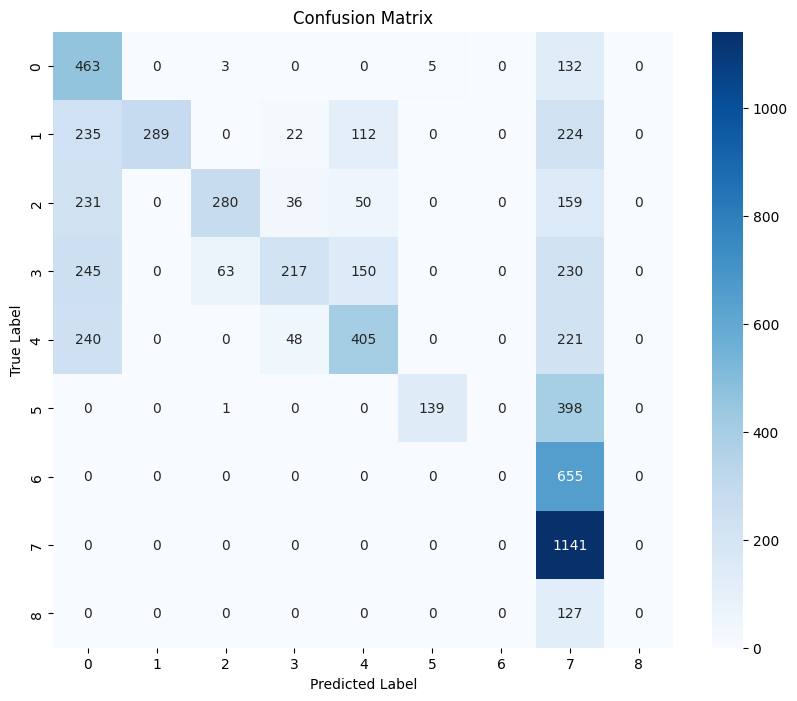

In [41]:
model = EEGNetTESANet(num_classes=num_classes)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(model)}")

# Assuming train_loader and test_loader are already defined
print("Training EEGNet:")
train_model(model, train_loader, test_loader)